# BT4012 Final Project 

## [1] Setting Up

#### [1.1] Import Statements

In [1]:
# import packages for data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# import packages for URL parsing
from urllib.parse import urlparse
from collections import Counter
import re
import tldextract
import ipaddress

# import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import packages for statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# import packages for model building


# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#### [1.2] Load Train Dataset

In [2]:
# load training data
df_train = pd.read_csv('dataset/train.csv')

In [3]:
df_train

url  \
0     http://cafecitoperez.ivanidzakovic.com/admin/aociufd/goodl.vci/e6edcebab88867a2f99a346ebaaf8179/view/login.php?cmd=login_submit&amp;id=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59&amp;session=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59   
1                                                                                                                                                                                                                                                          https://www.guiadoexcel.com.br/   
2                                                                       https://www.mysummercamps.com/forum/For_Camp_Directors_C3/Research_and_Learn_F10/Bridging_the_gap_at_summer_camp/gforum.cgi?url=http://server.bludomain82.com/~bree2/review/#_&amp;?hannah.judge@discsystems.co.uk   
3                                                                                                                                                                                                                                                           https://www.health-island.net/   
4                                                                                                                                                                                                                                              https://www.youtube.com/watch?v=0jqwikTk9gw   
...                                                                                                                                                                                                                                                                                    ...   
9138                                                                                                                                                                                                                                                   http://rebrand.ly/App_novo_cadastro   
9139                                                                                                                                                                                                                                                        http://whattsapp2020.ygto.com/   
9140                                                                                                                                                                                                                                      http://www.ezblox.site/free/jennifer111/helpdesk   
9141                                                                                                                                                                           https://part.eyrehead.com/lao?st=ZH9wlGpkcmKclbN6wpyUaHZ4YJ2OjJyepKZdZHy0j2lj/mathias.egloff%40chem.ethz.ch   
9142                                                                                                                http://fr.proxy.al/direct/aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tL2ltcHJlc3Npb24ucGhwL2YzNzM0MzE3ODcyMDI2Lz9saWQ9MTE1JnBheWxvYWQ9JTdCJTIyc291cmNlJTIyJTNBJTIyanNzZGslMjIlN0Q-   

      target  
0          1  
1          0  
2          1  
3          0  
4          0  
...      ...  
9138       1  
9139       1  
9140       1  
9141       1  
9142       1  

[9143 rows x 2 columns]

## [2] Feature Engineering
- At this section, we conduct feature engineering, to generate features based on URL
- All original features from the dataset were removed due to the lack of documentation on how they were created. Without clear definitions, these original features could not guarantee reproducibility, reliability, or interpretability, which are essential for a transparent and trustworthy model.
- Although many phishing datasets include additional features such as HTML-based attributes or traffic statistics, we intentionally restrict our feature set to URL-only features. This design choice ensures that the detector can be applied directly to raw URLs in real-world scenarios, where HTML content, domain metadata, or server-side information may not be easily accessible.

#### Breakdown of an URL (example)
https://subdomain.example.com:8080/path/to/file.html?key1=value1&key2=value2#section
- Scheme / Protocol: https
- Host / Domain: subdomain.example.com
    - Subdomain: subdomain
    - Second-Level-Domain (SLD): example
    - Top-Level-Domain (TLD): com
- Port: 8080
- Path: path/to/file.html
    - Directory-Path: path/to
    - Filename: file.html
    - File-Extension: html
- Query: key1=value1&key2=value2
    - Params: key1=value1 and key2=value2
- Fragment/Anchor: section

In [4]:
# decompose URL into its components
def decompose_single_url(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or None
    ext = tldextract.extract(hostname) if hostname else None
    
    # path decomposition
    path_parts = [p for p in parsed.path.split('/') if p] if parsed.path else []
    filename = path_parts[-1] if path_parts else None
    file_extension = filename.split('.')[-1] if filename and '.' in filename else None
    directory_path = '/'.join(path_parts[:-1]) if len(path_parts) > 1 else None
    
    # query parameters
    query_params = parsed.query.split('&') if parsed.query else None

    return {
        'url': url,
        'protocol': parsed.scheme or None,
        'hostname': hostname,
        'port': parsed.port if parsed.port is not None else None,
        'path': parsed.path or None,
        'query': parsed.query or None,
        'fragment': parsed.fragment or None,
        'subdomains': ext.subdomain if ext else None,
        'sld': ext.domain if ext else None,
        'tld': ext.suffix if ext else None,
        'filename': filename,
        'file_extension': file_extension,
        'directory_path': directory_path,
        'query_params': query_params
    }

def decompose_url(df):
    df_decomposed = df['url'].apply(lambda x: pd.Series(decompose_single_url(x)))
    df_decomposed = pd.concat([df_decomposed, df['target']], axis=1)
    # convert all empty strings to None
    df_decomposed.replace('', None, inplace=True)
    return df_decomposed

In [5]:
# feature engineering, extracting features from URL
def extract_url_features(df):

    final_df = df.copy()

    ## PROTOCOL FEATURES
    final_df['is_https'] = (final_df['protocol'] == 'https').astype(int)
    final_df['is_http'] = (final_df['protocol'] == 'http').astype(int)

    ## DOMAIN FEATURES
    final_df['has_subdomain'] = final_df['subdomains'].notna().astype(int)
    final_df['has_tld'] = final_df['tld'].notna().astype(int)
    final_df['num_subdomain'] = final_df['subdomains'].apply(lambda x: len(x.split('.')) if x else 0)
    # check if is IP address
    def is_ip_address(hostname):
        try:
            ipaddress.ip_address(hostname)
            return 1  
        except:
            return 0
    final_df['is_domain_ip'] = final_df['hostname'].apply(is_ip_address)
    # suspicious punctuation in domain
    final_df['num_hyphens_domain'] = final_df['hostname'].str.count('-')
    final_df['num_dots_domain'] = final_df['hostname'].str.count(r'\.')
    # detect punycode
    final_df['is_punycode'] = final_df['hostname'].str.contains('xn--', regex=False, na=False).astype(int)
    
    ## PORT FEATURES
    final_df['has_port'] = final_df['port'].notna().astype(int)

    ## PATH FEATURES
    final_df['has_path'] = final_df['path'].apply(lambda x: 1 if x and x != '/' else 0)
    final_df['path_depth'] = final_df['path'].apply(lambda x: len([p for p in x.split('/') if p]) if x else 0)
    final_df['has_directory_path'] = final_df['directory_path'].apply(lambda x: 1 if x and x != '/' else 0)

    ## FILE FEATURES
    final_df['has_filename'] = final_df['filename'].notna().astype(int)
    final_df['has_file_extension'] = final_df['file_extension'].notna().astype(int)

    ## QUERY FEATURES
    final_df['has_query'] = final_df['query'].notna().astype(int) 
    final_df['num_query_params'] = final_df['query_params'].apply(lambda x: len([p for p in x if p]) if x else 0)
    
    ## FRAGMENT FEATURES
    final_df['has_fragment'] = final_df['fragment'].notna().astype(int)

    ## LENGTH FEATURES
    final_df['length_url'] = final_df['url'].str.len()
    final_df['length_hostname'] = final_df['hostname'].str.len()
    final_df['length_tld'] = final_df['tld'].str.len()
    final_df['length_sld'] = final_df['sld'].str.len()
    final_df['length_subdomains'] = final_df['subdomains'].str.len()
    final_df['length_path'] = final_df['path'].str.len()
    final_df['length_query'] = final_df['query'].str.len()
    final_df['length_fragment'] = final_df['fragment'].str.len()

    ## PUNCTUATION FEATURES
    final_df['num_dots'] = final_df['url'].str.count(r'\.')
    final_df['num_hyphens'] = final_df['url'].str.count('-')
    final_df['num_at'] = final_df['url'].str.count('@')
    final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    final_df['num_and'] = final_df['url'].str.count('&')
    final_df['num_equal'] = final_df['url'].str.count('=') 
    final_df['num_slashes'] = final_df['url'].str.count('/')
    final_df['num_percent'] = final_df['url'].str.count('%')

    ## SUSPICIOUS PATTERNS FEATURES
    final_df['tld_in_path'] = final_df['path'].apply(lambda x: 1 if x and any(ext in x.lower() for ext in ['.com', '.net', '.org']) else 0)
    final_df['tld_in_subdomain'] = final_df['subdomains'].apply(lambda x: 1 if x and any(ext in x for ext in ['.com', '.net', '.org']) else 0)
    final_df['subdomain_longer_sld'] = (final_df['length_subdomains'] > final_df['length_sld']).astype(int)

    ## RATIO FEATURES
    final_df['ratio_digits_url'] = final_df['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_digits_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_letter_url'] = final_df['url'].apply(lambda x: sum(c.isalpha() for c in x) / len(x) if len(x) > 0 else 0)
    # proportion of components
    final_df['ratio_path_url'] = final_df['length_path'] / final_df['length_url']
    final_df['ratio_hostname_url'] = final_df['length_hostname'] / final_df['length_url']

    # WORD-BASED FEATURES 
    words_raw = final_df['url'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    words_host = final_df['hostname'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    words_path = final_df['path'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    final_df['length_words_url'] = words_raw.apply(len)
    final_df['avg_word_hostname'] = words_host.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    final_df['avg_word_path'] = words_path.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)

    ## CHARACTER BASED FEATURES
    final_df['num_unique_chars_hostname'] = final_df['hostname'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_non_ascii_url'] = final_df['url'].apply(lambda x: sum(1 for c in x if ord(c) > 127) if x else 0)

    # URL SHORTENING FEATURES
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 't.co']
    final_df['has_shortened_hostname'] = final_df['hostname'].str.lower().apply(lambda x: 1 if any(service in x for service in shortening_services) else 0)
    
    # ENTROPY FEATURES
    def calculate_entropy(domain):
        if not domain or len(domain) == 0:
            return 0
        domain_clean = re.sub(r'[^a-z]', '', domain.lower())
        if len(domain_clean) == 0:
            return 0
        char_freq = Counter(domain_clean)
        entropy = -sum((count/len(domain_clean)) * np.log2(count/len(domain_clean)) 
                      for count in char_freq.values())
        return entropy
    final_df['entropy_hostname'] = final_df['hostname'].apply(calculate_entropy)

    # convert numerical NaN to 0
    numerical_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols.remove('port')  # exclude 'port' as it is numerical but we want to keep NaN for missing ports
    final_df[numerical_cols] = final_df[numerical_cols].fillna(0)   

    return final_df

In [6]:
# section 2 function
def run_section_2(df):
    df_decomposed = decompose_url(df)
    df_features = extract_url_features(df_decomposed)
    return df_features

In [7]:
df_train_sec2 = run_section_2(df_train)

## [3] Preliminary Data Exploration and Preprocessing
- At this section, we conduct some basic data inspection before doing EDA. This includes checking for missing, duplicated rows, data types, as well as removing columns that hold no predictive meaning

#### [3.1] Data Inspection

In [8]:
# check first few rows
df_train_sec2.head()

url  \
0  http://cafecitoperez.ivanidzakovic.com/admin/aociufd/goodl.vci/e6edcebab88867a2f99a346ebaaf8179/view/login.php?cmd=login_submit&amp;id=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59&amp;session=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59   
1                                                                                                                                                                                                                                                       https://www.guiadoexcel.com.br/   
2                                                                    https://www.mysummercamps.com/forum/For_Camp_Directors_C3/Research_and_Learn_F10/Bridging_the_gap_at_summer_camp/gforum.cgi?url=http://server.bludomain82.com/~bree2/review/#_&amp;?hannah.judge@discsystems.co.uk   
3                                                                                                                                                                                                                                                        https://www.health-island.net/   
4                                                                                                                                                                                                                                           https://www.youtube.com/watch?v=0jqwikTk9gw   

  protocol                         hostname  port  \
0     http  cafecitoperez.ivanidzakovic.com   NaN   
1    https           www.guiadoexcel.com.br   NaN   
2    https            www.mysummercamps.com   NaN   
3    https            www.health-island.net   NaN   
4    https                  www.youtube.com   NaN   

                                                                                             path  \
0                        /admin/aociufd/goodl.vci/e6edcebab88867a2f99a346ebaaf8179/view/login.php   
1                                                                                               /   
2  /forum/For_Camp_Directors_C3/Research_and_Learn_F10/Bridging_the_gap_at_summer_camp/gforum.cgi   
3                                                                                               /   
4                                                                                          /watch   

                                                                                                                                                                   query  \
0  cmd=login_submit&amp;id=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59&amp;session=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59   
1                                                                                                                                                                   None   
2                                                                                                                       url=http://server.bludomain82.com/~bree2/review/   
3                                                                                                                                                                   None   
4                                                                                                                                                          v=0jqwikTk9gw   

                                fragment     subdomains            sld  \
0                                   None  cafecitoperez  ivanidzakovic   
1                                   None            www    guiadoexcel   
2  _&amp;?hannah.judge@discsystems.co.uk            www  mysummercamps   
3                                   None            www  health-island   
4                                   None            www        youtube   

      tld    filename file_extension  \
0     com   login.php            php   
1  com.br        None           None   
2     com  gforum.cgi            cgi   
3     net    

In [9]:
# check shape of dataset
df_train_sec2.shape

(9143, 64)

In [10]:
# check for duplicate rows
df_temp = df_train_sec2.copy()
for col in df_temp.columns:
    df_temp[col] = df_temp[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_temp.duplicated().sum()


np.int64(0)

In [11]:
# check for null 
df_train_sec2.isna().sum()

url                             0
protocol                        0
hostname                        0
port                         9119
path                          515
                             ... 
avg_word_path                   0
num_unique_chars_hostname       0
num_non_ascii_url               0
has_shortened_hostname          0
entropy_hostname                0
Length: 64, dtype: int64

In [12]:
# check data type
df_train_sec2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9143 entries, 0 to 9142
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   url                        9143 non-null   object 
 1   protocol                   9143 non-null   object 
 2   hostname                   9143 non-null   object 
 3   port                       24 non-null     float64
 4   path                       8628 non-null   object 
 5   query                      1223 non-null   object 
 6   fragment                   38 non-null     object 
 7   subdomains                 7035 non-null   object 
 8   sld                        9143 non-null   object 
 9   tld                        9063 non-null   object 
 10  filename                   6433 non-null   object 
 11  file_extension             2413 non-null   object 
 12  directory_path             4554 non-null   object 
 13  query_params               1223 non-null   objec

Insights:
- There are no duplicated data thus no further processing is required
- There are some null datas which will be handled later
- There are float, int and object data types. Some fields seems to be boolean but are stored as int64
- Columns like `port` and `length_fragment` have very little counts (very sparse), thus can consider removing them in our analysis. 

Plan:
- Convert boolean columns to the correct data type to facilitate downstream use cases
- Remove `port` and `fragment` related features
    - Most of the real world URL will not include the port information
    - Fragment portion of URL is never sent to server and this is rarely included in real world URL
    - Most importantly, missingness of this field is not informative and there is too less data to learning meaningful patterns

#### [3.2] Drop unnecessary columns and convert data types

In [13]:
# section 3 function
def run_section_3(df):
    # drop 'port' and 'fragment' related features due to high missingness and low informativeness
    df = df.drop(columns=['port', 'has_port', 'fragment', 'has_fragment', 'length_fragment'])

    # convert boolean columns to 'bool' data type - all 'is_' and 'has_' columns
    bool_columns = [col for col in df.columns if col.startswith('is_') or col.startswith('has_')]
    bool_columns.append('subdomain_longer_sld')
    bool_columns.append('tld_in_subdomain')
    bool_columns.append('tld_in_path')
    for col in bool_columns:
        df[col] = df[col].astype(bool)
    return df

In [86]:
df_train_sec3 = run_section_3(df_train_sec2)

In [15]:
df_train_sec3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9143 entries, 0 to 9142
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   url                        9143 non-null   object 
 1   protocol                   9143 non-null   object 
 2   hostname                   9143 non-null   object 
 3   path                       8628 non-null   object 
 4   query                      1223 non-null   object 
 5   subdomains                 7035 non-null   object 
 6   sld                        9143 non-null   object 
 7   tld                        9063 non-null   object 
 8   filename                   6433 non-null   object 
 9   file_extension             2413 non-null   object 
 10  directory_path             4554 non-null   object 
 11  query_params               1223 non-null   object 
 12  target                     9143 non-null   int64  
 13  is_https                   9143 non-null   bool 

## [4] Exploratory Data Analysis
- At this section, we conduct the EDA
- A structured approach is followed, looking at descriptive analysis for numerical and categorical / binary variables as well as outlier analysis first. The purpose is to better understand each variable distribution, and see if any further processing is needed, such as transformation or scaling.
- Then, we conducted qualitative and quantitative correlation analysis. The purpose was to understand the relationship between features as well as the relationship between features with the target, and see if any further processing is needed, such as removing of highly correlated features or features with limited predictive power.
- Lastly, we also conducted EDA on the text features

#### [4.1] Descriptive Analysis for numerical variables

In [16]:
# get numerical variables and calculate summary statistics
numerical_variables = df_train_sec3.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_variables.remove('target')  
descriptive_stats_numerical = df_train_sec3[numerical_variables].describe().T
descriptive_stats_numerical['mode'] = df_train_sec3[numerical_variables].mode().transpose()[0]
descriptive_stats_numerical['mad'] = [stats.median_abs_deviation(df_train_sec3[x]) for x in numerical_variables]
descriptive_stats_numerical['kurtosis'] = [stats.kurtosis(df_train_sec3[x], fisher=True) for x in numerical_variables]
descriptive_stats_numerical['skewness'] = [stats.skew(df_train_sec3[x]) for x in numerical_variables]
descriptive_stats_numerical

count       mean        std        min        25%  \
num_subdomain              9143.0   0.954173   0.851203   0.000000   1.000000   
num_hyphens_domain         9143.0   0.215684   0.617214   0.000000   0.000000   
num_dots_domain            9143.0   2.047577   0.856998   1.000000   2.000000   
path_depth                 9143.0   1.814831   1.896395   0.000000   0.000000   
num_query_params           9143.0   0.286667   1.014964   0.000000   0.000000   
length_url                 9143.0  60.778082  56.468085  12.000000  32.000000   
length_hostname            9143.0  21.054905  10.560555   4.000000  15.000000   
length_tld                 9143.0   3.040359   0.953072   0.000000   3.000000   
length_sld                 9143.0  10.115061   4.667680   1.000000   7.000000   
length_subdomains          9143.0   6.138576   9.628993   0.000000   2.000000   
length_path                9143.0  22.956798  27.920904   0.000000   1.000000   
length_query               9143.0   9.034124  46.004712   0.000000   0.000000   
num_dots                   9143.0   2.472383   1.392418   1.000000   2.000000   
num_hyphens                9143.0   0.990485   2.016725   0.000000   0.000000   
num_at                     9143.0   0.021328   0.152583   0.000000   0.000000   
num_question_marks         9143.0   0.139670   0.362096   0.000000   0.000000   
num_and                    9143.0   0.158810   0.816010   0.000000   0.000000   
num_equal                  9143.0   0.289183   0.994703   0.000000   0.000000   
num_slashes                9143.0   4.278136   1.892763   2.000000   3.000000   
num_percent                9143.0   0.126217   1.555871   0.000000   0.000000   
ratio_digits_url           9143.0   0.052713   0.089284   0.000000   0.000000   
ratio_digits_hostname      9143.0   0.025175   0.094039   0.000000   0.000000   
ratio_letter_url           9143.0   0.761644   0.084937   0.181818   0.727273   
ratio_path_url             9143.0   0.323200   0.254901   0.000000   0.041667   
ratio_hostname_url         9143.0   0.446484   0.210556   0.010823   0.276253   
length_words_url           9143.0   8.086514   5.421811   3.000000   5.000000   
avg_word_hostname          9143.0   5.816031   2.065305   1.500000   4.333333   
avg_word_path              9143.0   5.129522   6.980380   0.000000   0.000000   
num_unique_chars_hostname  9143.0  12.630537   3.476048   2.000000  10.000000   
num_non_ascii_url          9143.0   0.014765   1.339495   0.000000   0.000000   
entropy_hostname           9143.0   3.247146   0.501375  -0.000000   3.026987   

                                 50%        75%          max       mode  \
num_subdomain               1.000000   1.000000    13.000000   1.000000   
num_hyphens_domain          0.000000   0.000000    19.000000   0.000000   
num_dots_domain             2.000000   2.000000    14.000000   2.000000   
path_depth                  1.000000   3.000000    27.000000   0.000000   
num_query_params            0.000000   0.000000    20.000000   0.000000   
length_url                 47.000000  70.000000  1641.000000  32.000000   
length_hostname            19.000000  24.000000   214.000000  16.000000   
length_tld                  3.000000   3.000000    12.000000   3.000000   
length_sld                  9.000000  13.000000    44.000000   8.000000   
length_subdomains           3.000000   6.000000   202.000000   3.000000   
length_path                17.000000  33.000000   602.000000   1.000000   
length_query                0.000000   0.000000  1585.000000   0.000000   
num_dots                    2.000000   3.000000    24.000000   2.000000   
num_hyphens                 0.000000   1.000000    32.000000   0.000000   
num_at                      0.000000   0.000000     4.000000   0.000000   
num_question_marks          0.000000   0.000000     3.000000   0.000000   
num_and                     0.000000   0.000000    19.000000   0.000000   
num_equal                   0.000000   0.000000    19.000000   0.000000   
num_slashe

Insights:
- Columns like `num_non_ascii_url` are highly skewed 
- Columns like `length_path` seems to be on a very different scale compared to the other variables 

Plan:
- For models like logistic regression, can perform relevant transformation to change the distribution of the data, making skewed features closer to normal distribution, in order to improve the performance of the model
- For distance based models that are sensitive to scale like SVM or models that rely on gradient descent, can perform scaling of features for more accurate computations and to improve speed of convergence


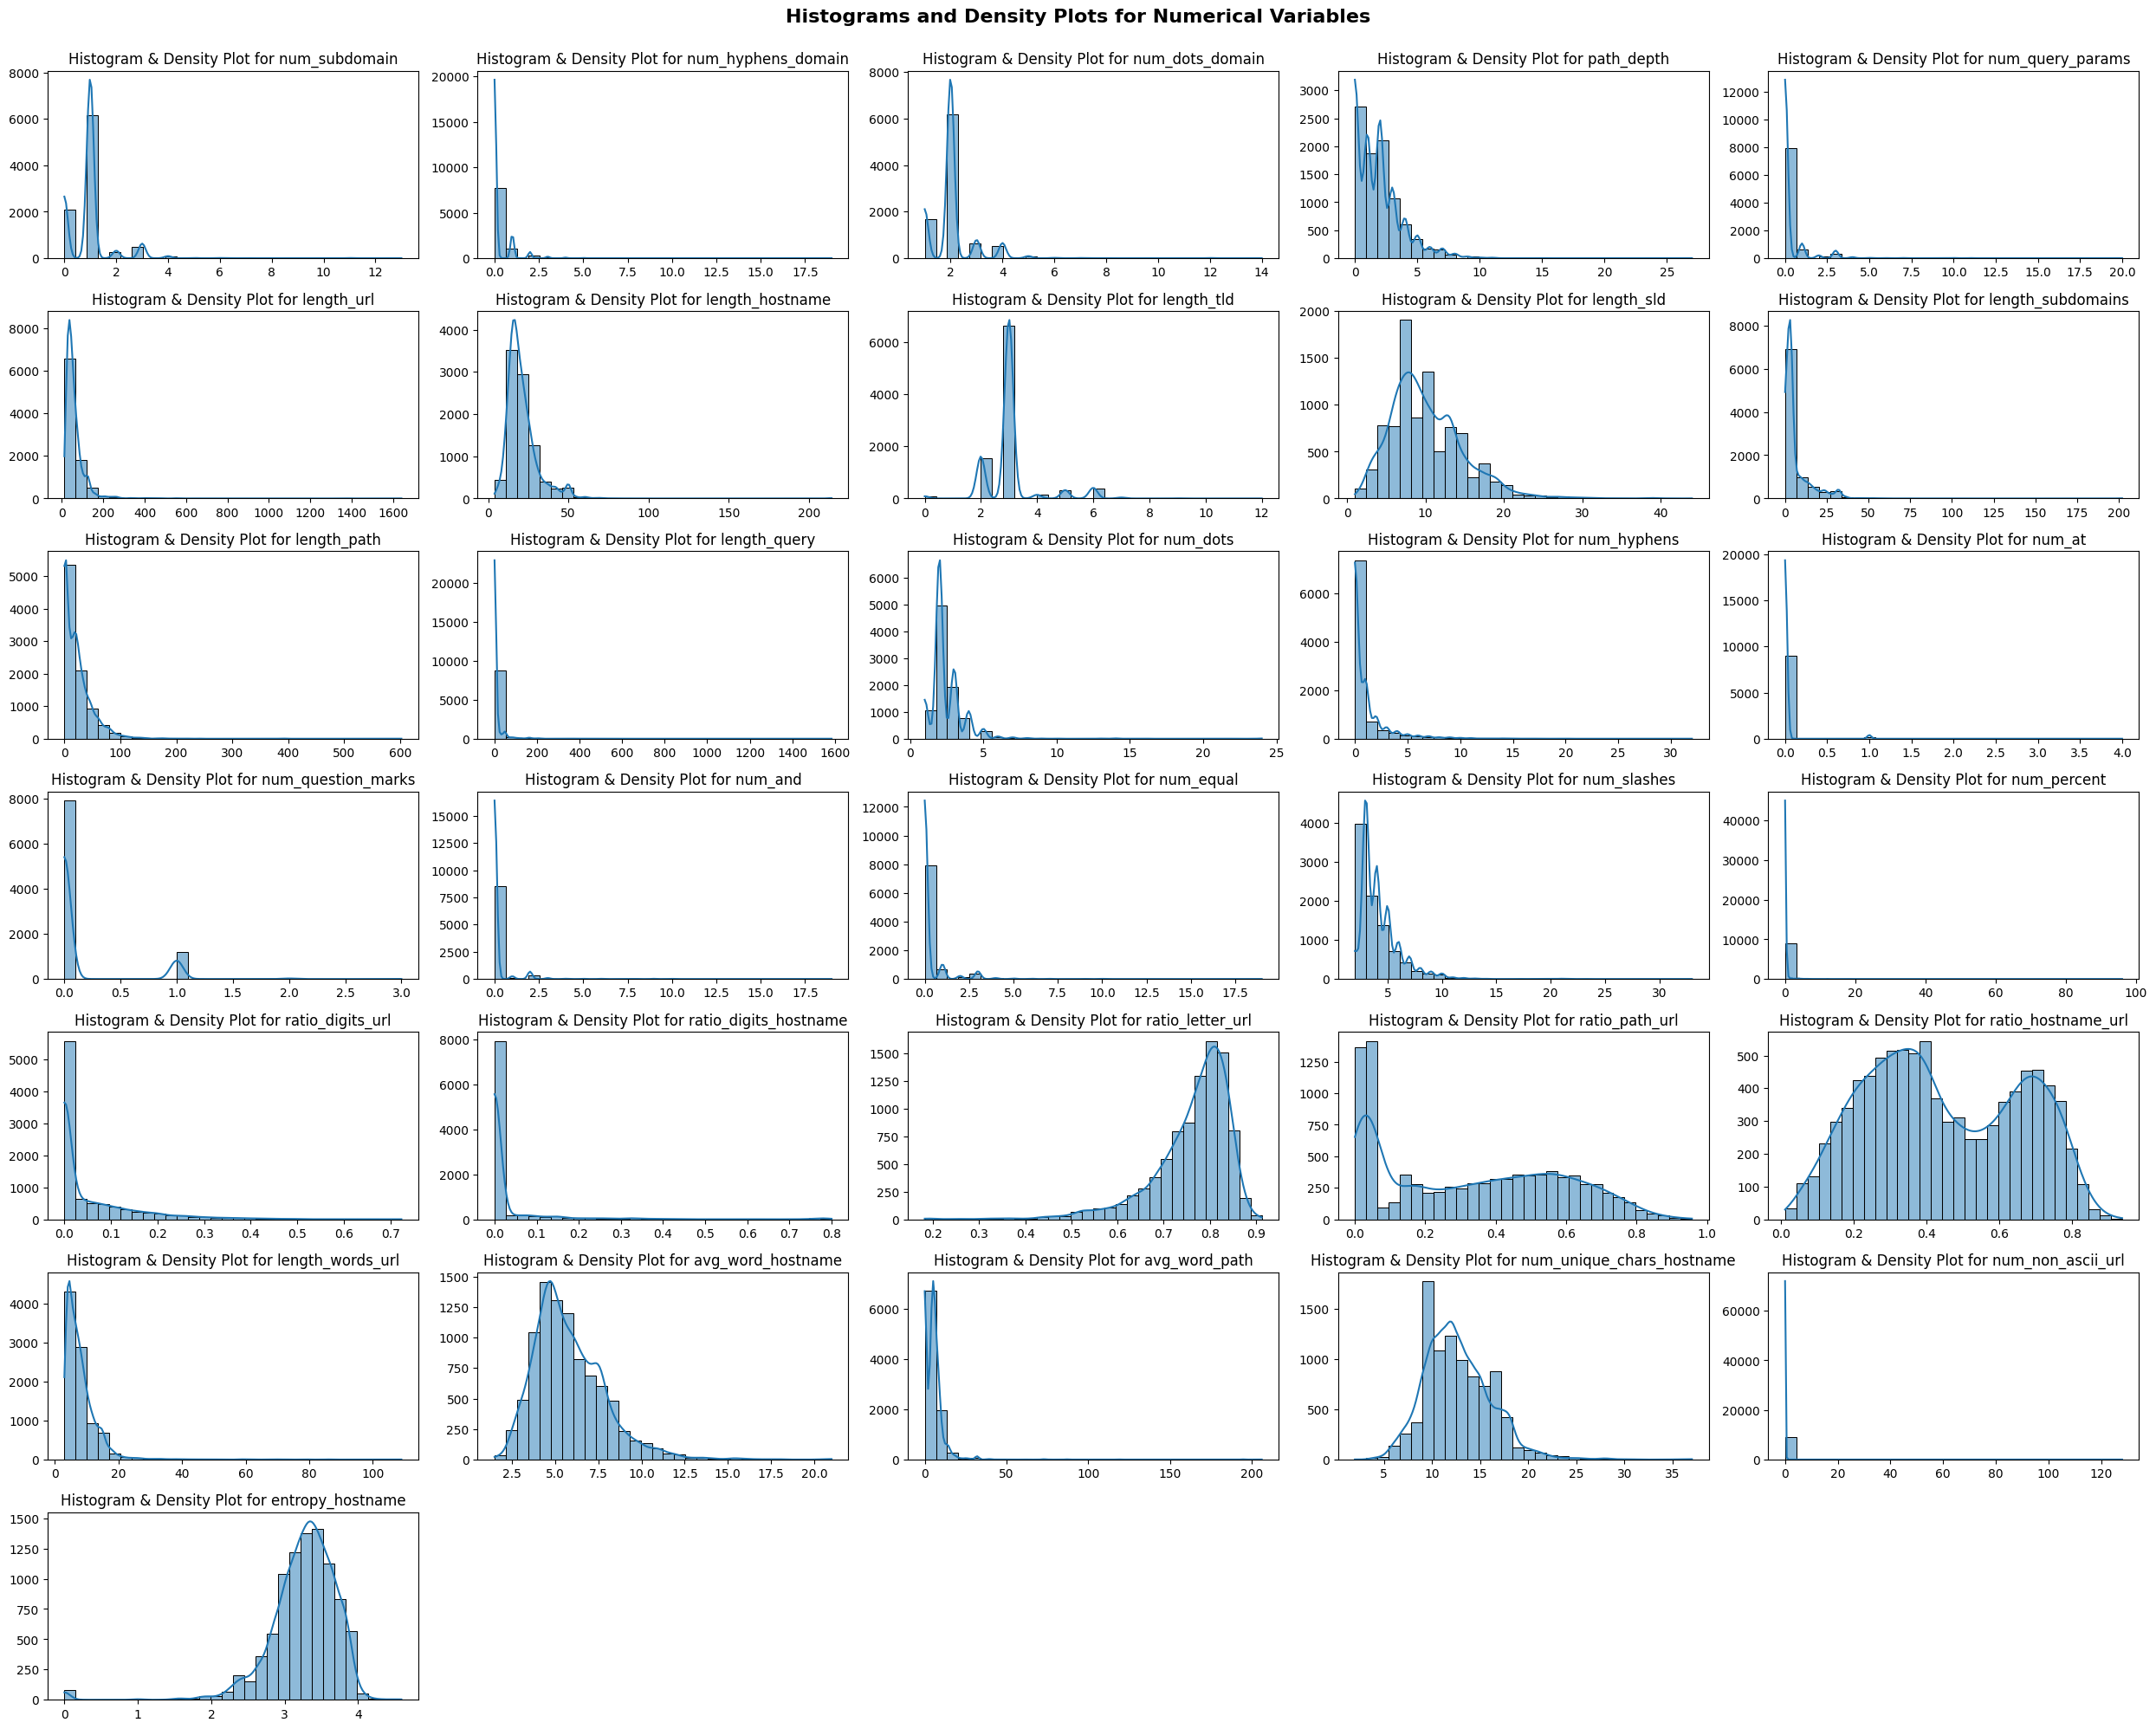

In [17]:
# temp df to plot
df_train_sec3_temp = df_train_sec3.copy()

# plot histograms and kde for numerical variables
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(5 * 5, 7 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Numerical Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(numerical_variables):
    ax = axes[i]
    sns.histplot(data=df_train_sec3_temp, x=var_name, kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

Insights:
- There are quite a lot of columns that are heavily right skewed like with only an extreme left peak eg. `num_hyphens` where there seems to be a large amount of outliers present.
- There are also some columns that are moderately right skewed like eg. `avg_word_hostname`.
- There are some columns that are left skewed like eg. `ratio_letter_url`
- Lastly, columns like `length_hostname` seem to be rather normally distributed

Plan:
- We can try a log transform or use other transformation technique to make the variables that are right skewed more normally distributed
- For left skewed, can try a square transformation
- For columns with strong peak (eg extreme left peak), can convert to boolean variables instead to focus on capturing that relationship


##### [4.1.1] Apply Transformation and Visualise

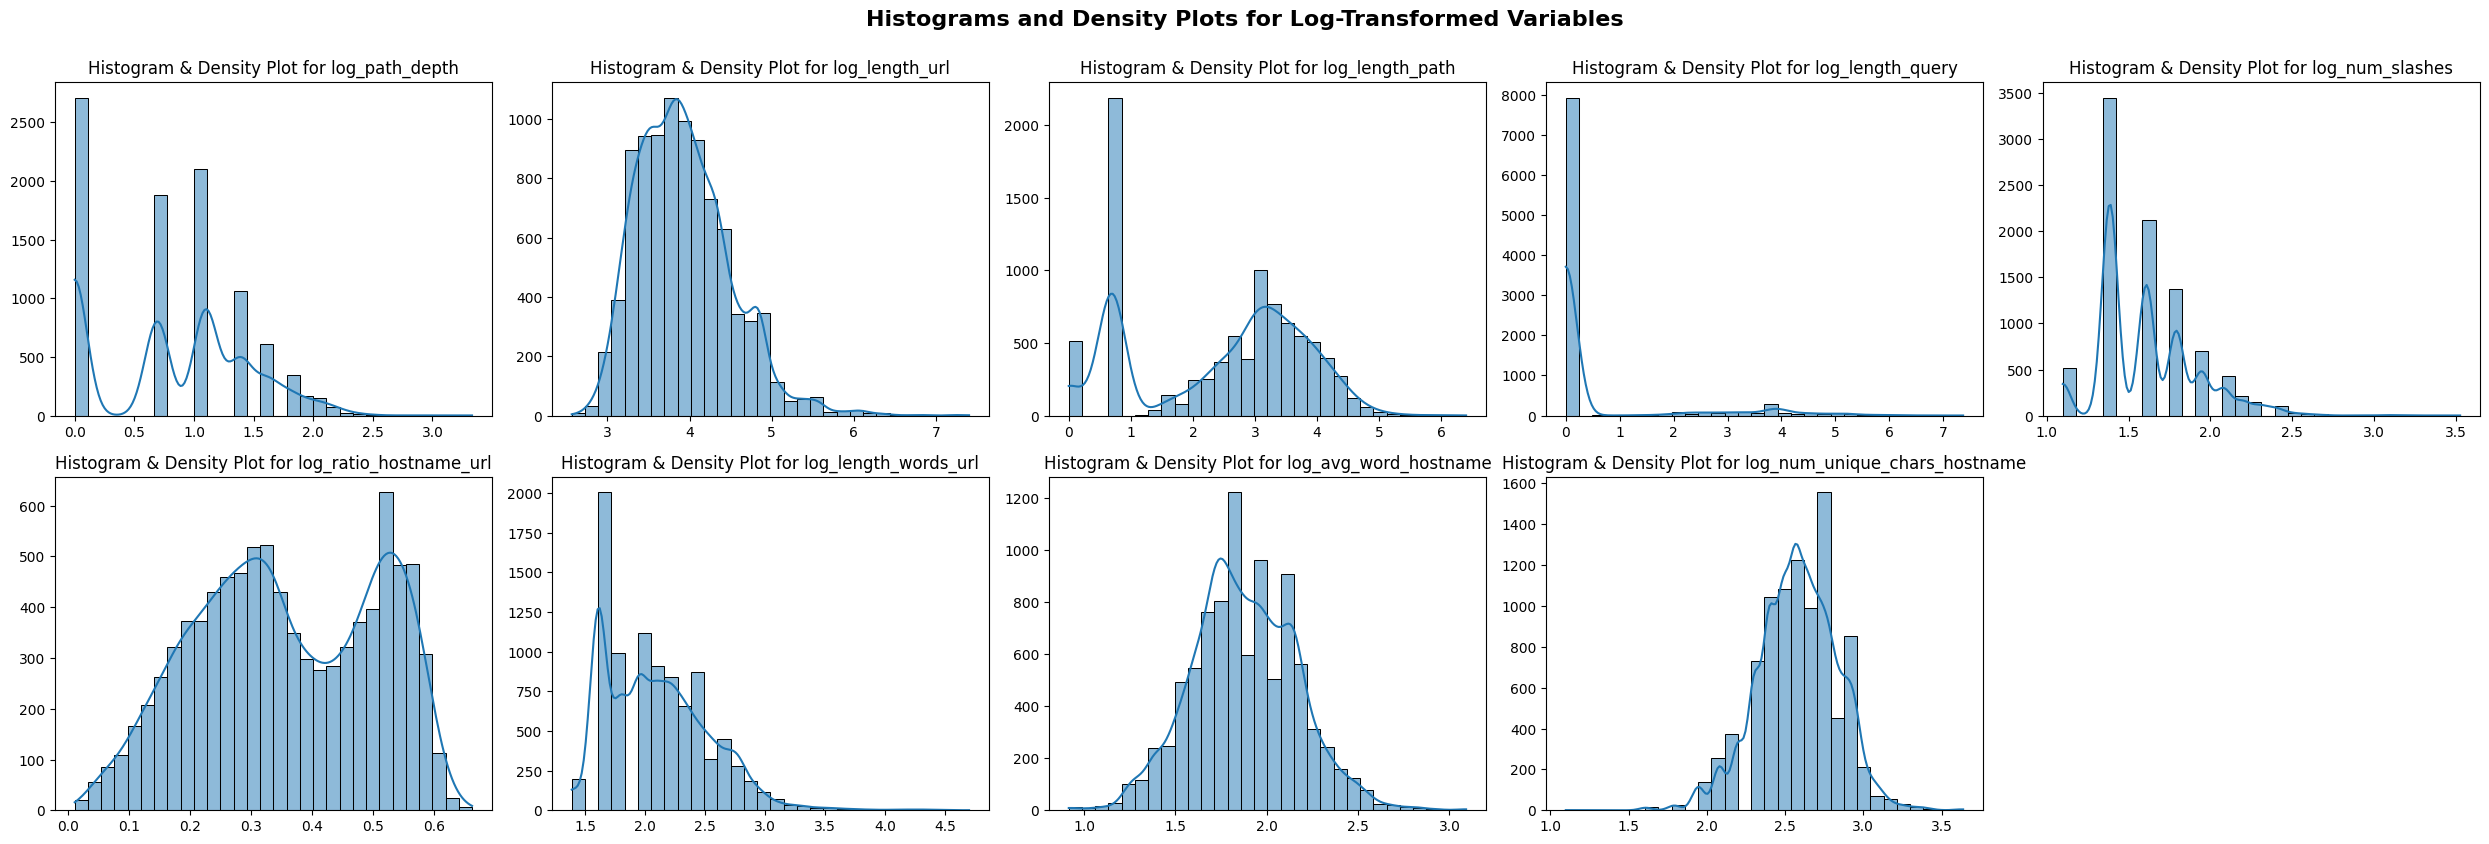

In [18]:
# log-transformed variables
df_train_transformed = df_train_sec3_temp.copy()
transform_variables = [ 'path_depth', 'length_url','length_path', 'length_query',  'num_slashes', 'ratio_hostname_url', 'length_words_url',
                       'avg_word_hostname', 'num_unique_chars_hostname']
for var in transform_variables:
    df_train_transformed[f"log_{var}"] = np.log1p(df_train_transformed[var])

# visualise log transformed variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Log-Transformed Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(transform_variables):
    ax = axes[i]
    sns.histplot(data=df_train_transformed, x=f"log_{var_name}", kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for log_{var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(transform_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()


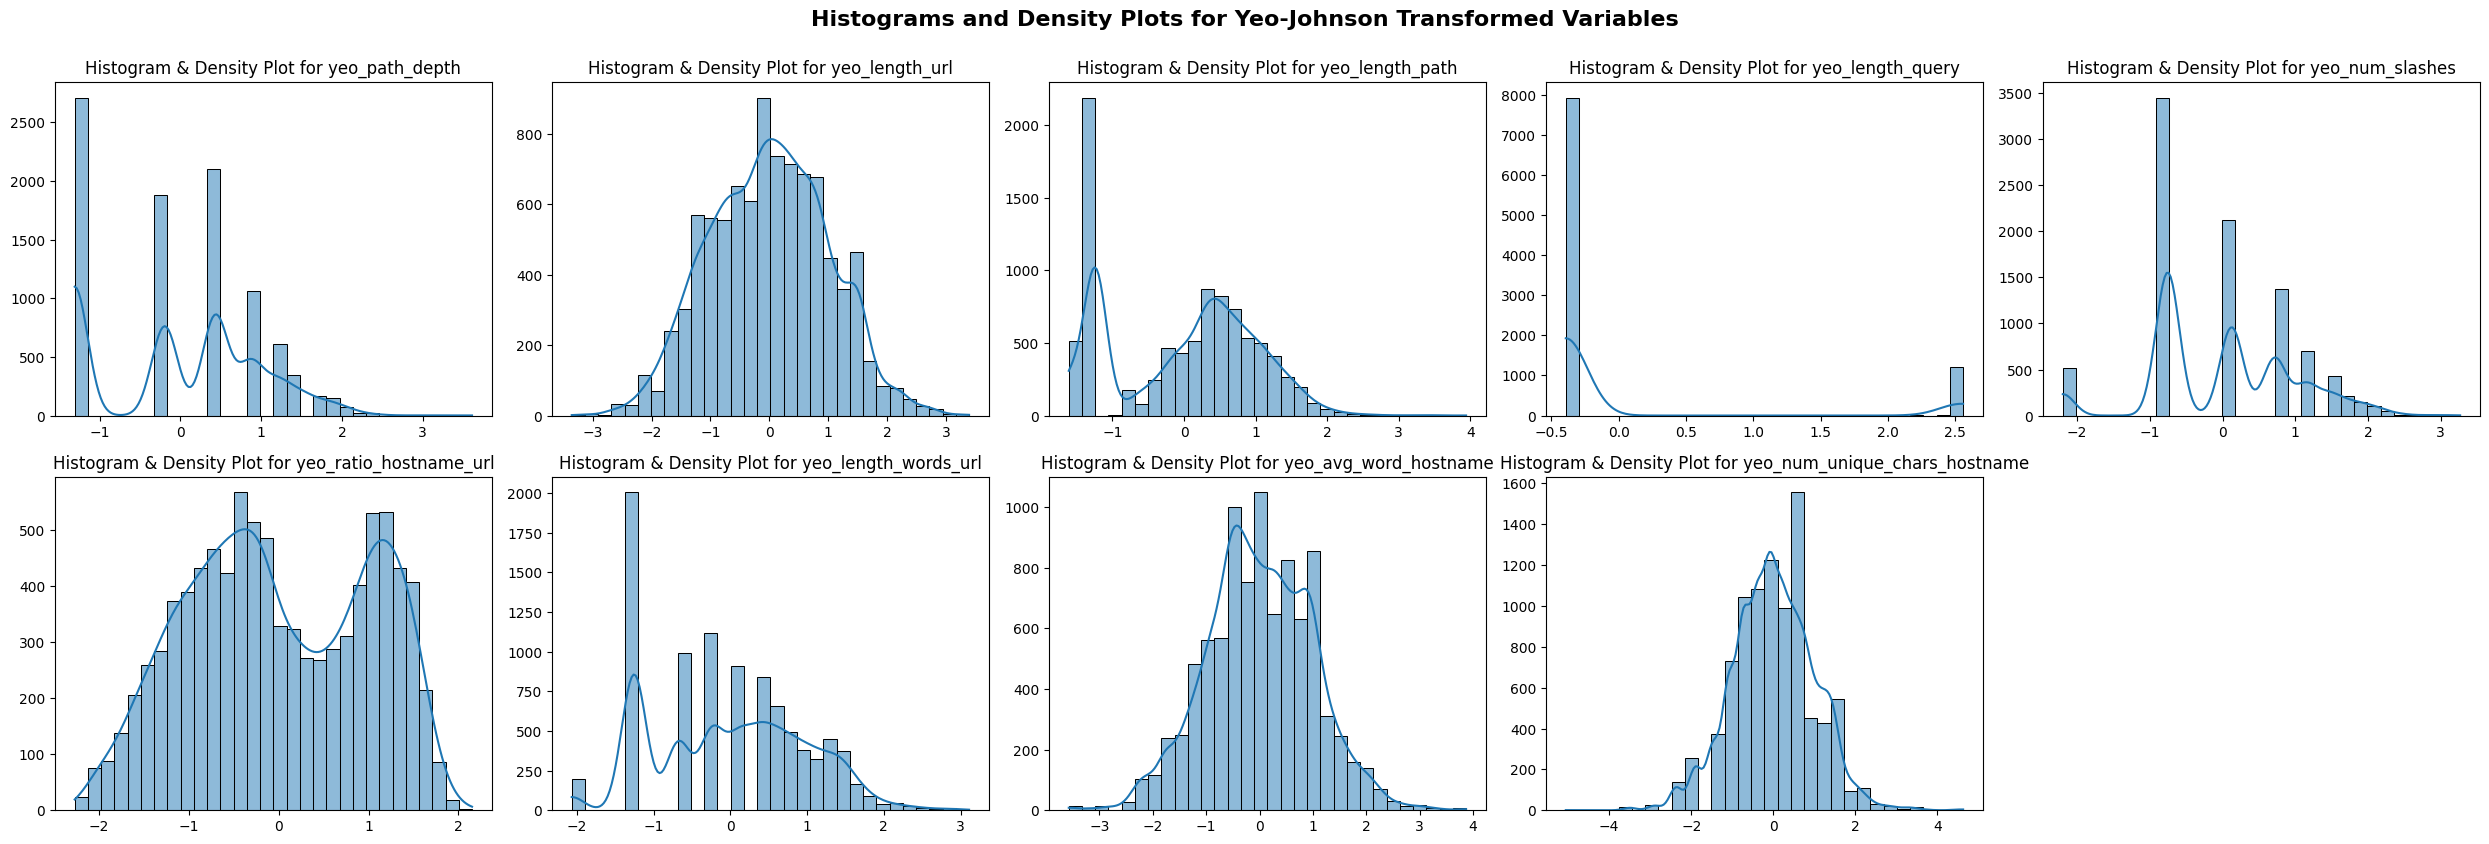

In [19]:
# Yeo-Johnson transformed variables
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_train_transformed[[f"yeo_{var}" for var in transform_variables]] = pt.fit_transform(df_train_transformed[transform_variables])

# visualise Yeo-Johnson transformed variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Yeo-Johnson Transformed Variables', fontsize=16, fontweight='bold', y=1)

for i, var_name in enumerate(transform_variables):
    ax = axes[i]
    sns.histplot(data=df_train_transformed, x=f"yeo_{var_name}", kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for yeo_{var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(transform_variables), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Insights:
- After trying log-transform and Yeo-Johnson transform (a form of box cox transformation that is more robust for making our data normal and at the same time it works well with zero and negative values), we see that some of the features like eg. `length_url` are now approximately normally distributed
- But there are some features like eg. `path_depth`, `num_slashes` that seems to be a discrete numerical variable instead of a continuous variable
- Also, some features like eg. `length_path` shows a strong peak at value = 0, while rest of the values show an approximately normal distribution

Plan: 
- We can look at the number of unique values for these numerical variables to determine if it is discrete or continuous. For continuous, we can proceed with transformation to make them approximately normal, to be used for models like logistic regression. For discrete, we need to treat it as a categorical variable through one hot encoding or binning for models like logistic regression.
    - For discrete variables, if we leave values as it is, linear models like log regression can make linear assumptions which might not be accurate
- For those features with strong peaks at a specific value (eg. 0), we can create another boolean feature to better capture this relationship
    - Not needed for tree-based models

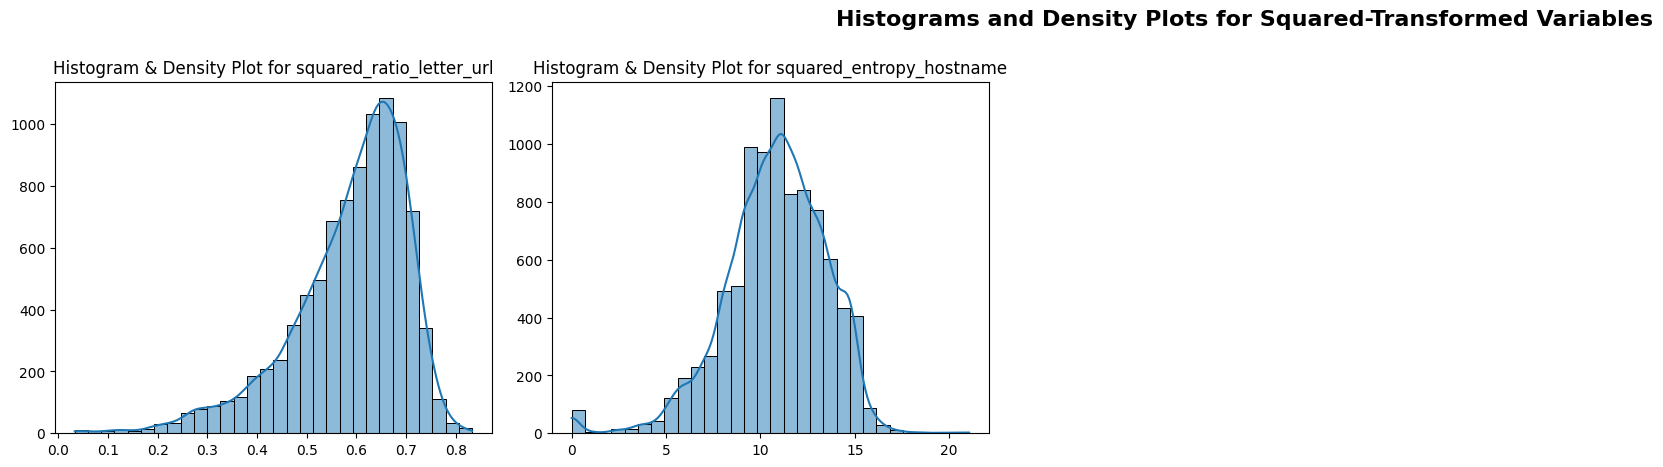

In [20]:
# try square transform left skewed
df_train_transformed = df_train_sec3_temp.copy()
transform_variables = ['ratio_letter_url', 'entropy_hostname']
for var in transform_variables:
    df_train_transformed[f"squared_{var}"] = np.square(df_train_transformed[var])

# visualise log transformed variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Squared-Transformed Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(transform_variables):
    ax = axes[i]
    sns.histplot(data=df_train_transformed, x=f"squared_{var_name}", kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for squared_{var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(transform_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()


Insights:
- Squared transform have made these left skewed variables more normal

##### [4.1.2] Determine if numerical variables are discrete or continuous

In [21]:
check_numerical_vars = []
for col in numerical_variables:
    if col in df_train_sec3_temp:
        num_unique = df_train_sec3_temp[col].nunique()
        dtype = df_train_sec3_temp[col].dtype
        check_numerical_vars.append({"Column": col, "Type": dtype, "Unique Values": num_unique})
    else:
        check_numerical_vars.append({"Column": col, "Type": "Not Found", "Unique Values": "N/A"})
check_numerical_vars_df = pd.DataFrame(check_numerical_vars)
print(check_numerical_vars_df.sort_values(by="Unique Values"))

                       Column     Type  Unique Values
15         num_question_marks    int64              4
29          num_non_ascii_url    int64              5
14                     num_at    int64              5
1          num_hyphens_domain    int64              9
7                  length_tld  float64             12
0               num_subdomain    int64             12
2             num_dots_domain    int64             12
16                    num_and    int64             15
4            num_query_params    int64             16
17                  num_equal    int64             16
12                   num_dots    int64             18
3                  path_depth    int64             18
18                num_slashes    int64             21
19                num_percent    int64             21
13                num_hyphens    int64             24
28  num_unique_chars_hostname    int64             32
8                  length_sld    int64             39
25           length_words_ur

Insights:
- For features like `num_question_marks`, `num_non_ascii_url`, etc they have relatively lower number of unique values

Plan:
- For these features, don't need to do additional transformation 
- For features with clear distinct values like `path_depth`, `num_slashes`, can bucket instead based on the log-transformed plot.

##### [4.1.3] Determine numerical columns with large peaks for certain value
- By visual inspection

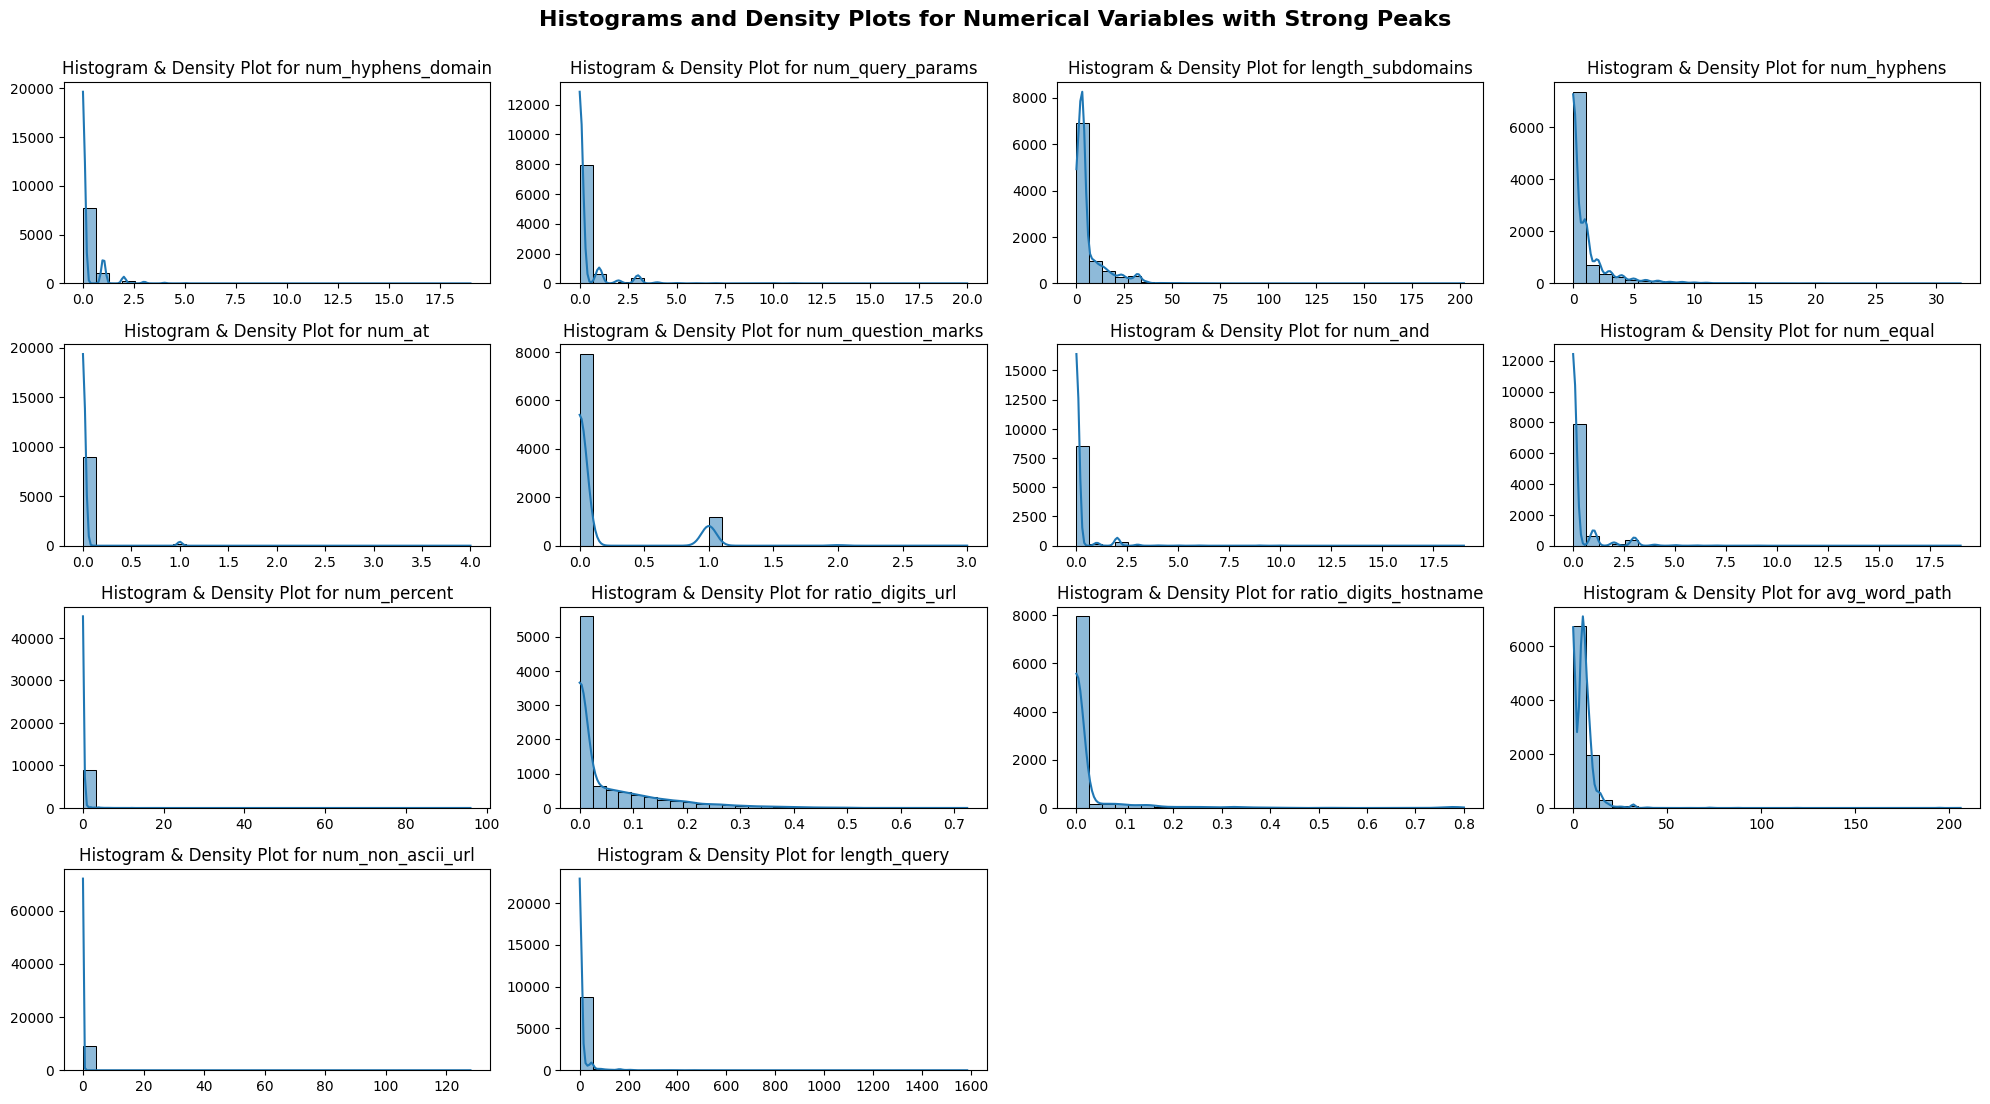

In [22]:
numerical_vars_with_strong_peaks = ['num_hyphens_domain',  'num_query_params', 'length_subdomains',
                                    'num_hyphens',  'num_at',  'num_question_marks', 'num_and',  'num_equal',
                                    'num_percent', 'ratio_digits_url',  'ratio_digits_hostname',
                                    'avg_word_path',  'num_non_ascii_url', 'length_query']

# plot out the histograms for numerical variables with strong peaks
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(4 * 5, 4 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Numerical Variables with Strong Peaks', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(numerical_vars_with_strong_peaks):
    ax = axes[i]
    sns.histplot(data=df_train_sec3_temp, x=var_name, kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')   
for i in range(len(numerical_vars_with_strong_peaks), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

In [23]:
# create the is_zero cols so we can plot them as boolean next time 
numerical_vars_with_strong_peaks = ['num_hyphens_domain',  'num_query_params', 'length_subdomains',
                                    'num_hyphens',  'num_at',  'num_question_marks', 'num_and',  'num_equal',
                                    'num_percent', 'ratio_digits_url',  'ratio_digits_hostname',
                                    'avg_word_path',  'num_non_ascii_url', 'length_query']
for var in numerical_vars_with_strong_peaks:
    df_train_sec3_temp[f'is_zero_{var}'] = (df_train_sec3_temp[var] == 0).astype(bool)

Plan:
- Convert these fields to boolean `is_zero_`

##### [4.1.4] Bucket certain fields and create to categorical or boolean
- By visual inspection

In [24]:
numerical_vars_with_distinct_vals = ['num_subdomain',  'num_dots_domain',  'length_tld', 'path_depth', 'num_slashes']

for col in numerical_vars_with_distinct_vals:
    print(f"Column: {col}")
    print(df_train_sec3_temp[col].value_counts().sort_index())
    print(f"Number of distinct values: {df_train_sec3_temp[col].nunique()}")
    print("-"*40)


Column: num_subdomain
num_subdomain
0     2108
1     6173
2      258
3      500
4       70
5        9
6        7
7        6
8        3
11       7
12       1
13       1
Name: count, dtype: int64
Number of distinct values: 12
----------------------------------------
Column: num_dots_domain
num_dots_domain
1     1684
2     6200
3      629
4      522
5       71
6       12
7        7
8        6
9        3
12       7
13       1
14       1
Name: count, dtype: int64
Number of distinct values: 12
----------------------------------------
Column: length_tld
length_tld
0.0       80
2.0     1549
3.0     6629
4.0      135
5.0      309
6.0      393
7.0       35
8.0        1
9.0        6
10.0       4
11.0       1
12.0       1
Name: count, dtype: int64
Number of distinct values: 12
----------------------------------------
Column: path_depth
path_depth
0     2710
1     1879
2     2100
3     1064
4      607
5      345
6      170
7      149
8       69
9       25
10      10
11       8
15       2
18       1

In [25]:
# from above, we can bucket the above fields
# NUM SUBDOMAIN: <1, 1, >1
df_train_sec3_temp['num_subdomain_bucketed'] = pd.cut(
    df_train_sec3_temp['num_subdomain'],
    bins=[-1, 0, 1, np.inf],
    labels=['0', '1', '2+']
)

# NUM DOTS DOMAIN: <2, 2, >2
df_train_sec3_temp['num_dots_domain_bucketed'] = pd.cut(
    df_train_sec3_temp['num_dots_domain'],
    bins=[-1, 1, 2, np.inf],
    labels=['0-1', '2', '3+']
)

# LENGTH TLD: <3, 3, >3
df_train_sec3_temp['length_tld_bucketed'] = pd.cut(
    df_train_sec3_temp['length_tld'],
    bins=[-1, 2, 3, np.inf],
    labels=['<3', '3', '>3']
)

# PATH DEPTH: <2, 2-3, >3
df_train_sec3_temp['path_depth_bucketed'] = pd.cut(
    df_train_sec3_temp['path_depth'],
    bins=[-1, 1, 3, np.inf],
    labels=['<2', '2-3', '>3']
)

# NUM SLASHES: <3, 3-5, >5
df_train_sec3_temp['num_slashes_bucketed'] = pd.cut(
    df_train_sec3_temp['num_slashes'],
    bins=[-1, 2, 5, np.inf],
    labels=['<3', '3-5', '>5']
)

#### [4.2] Outlier Analysis for numerical variables

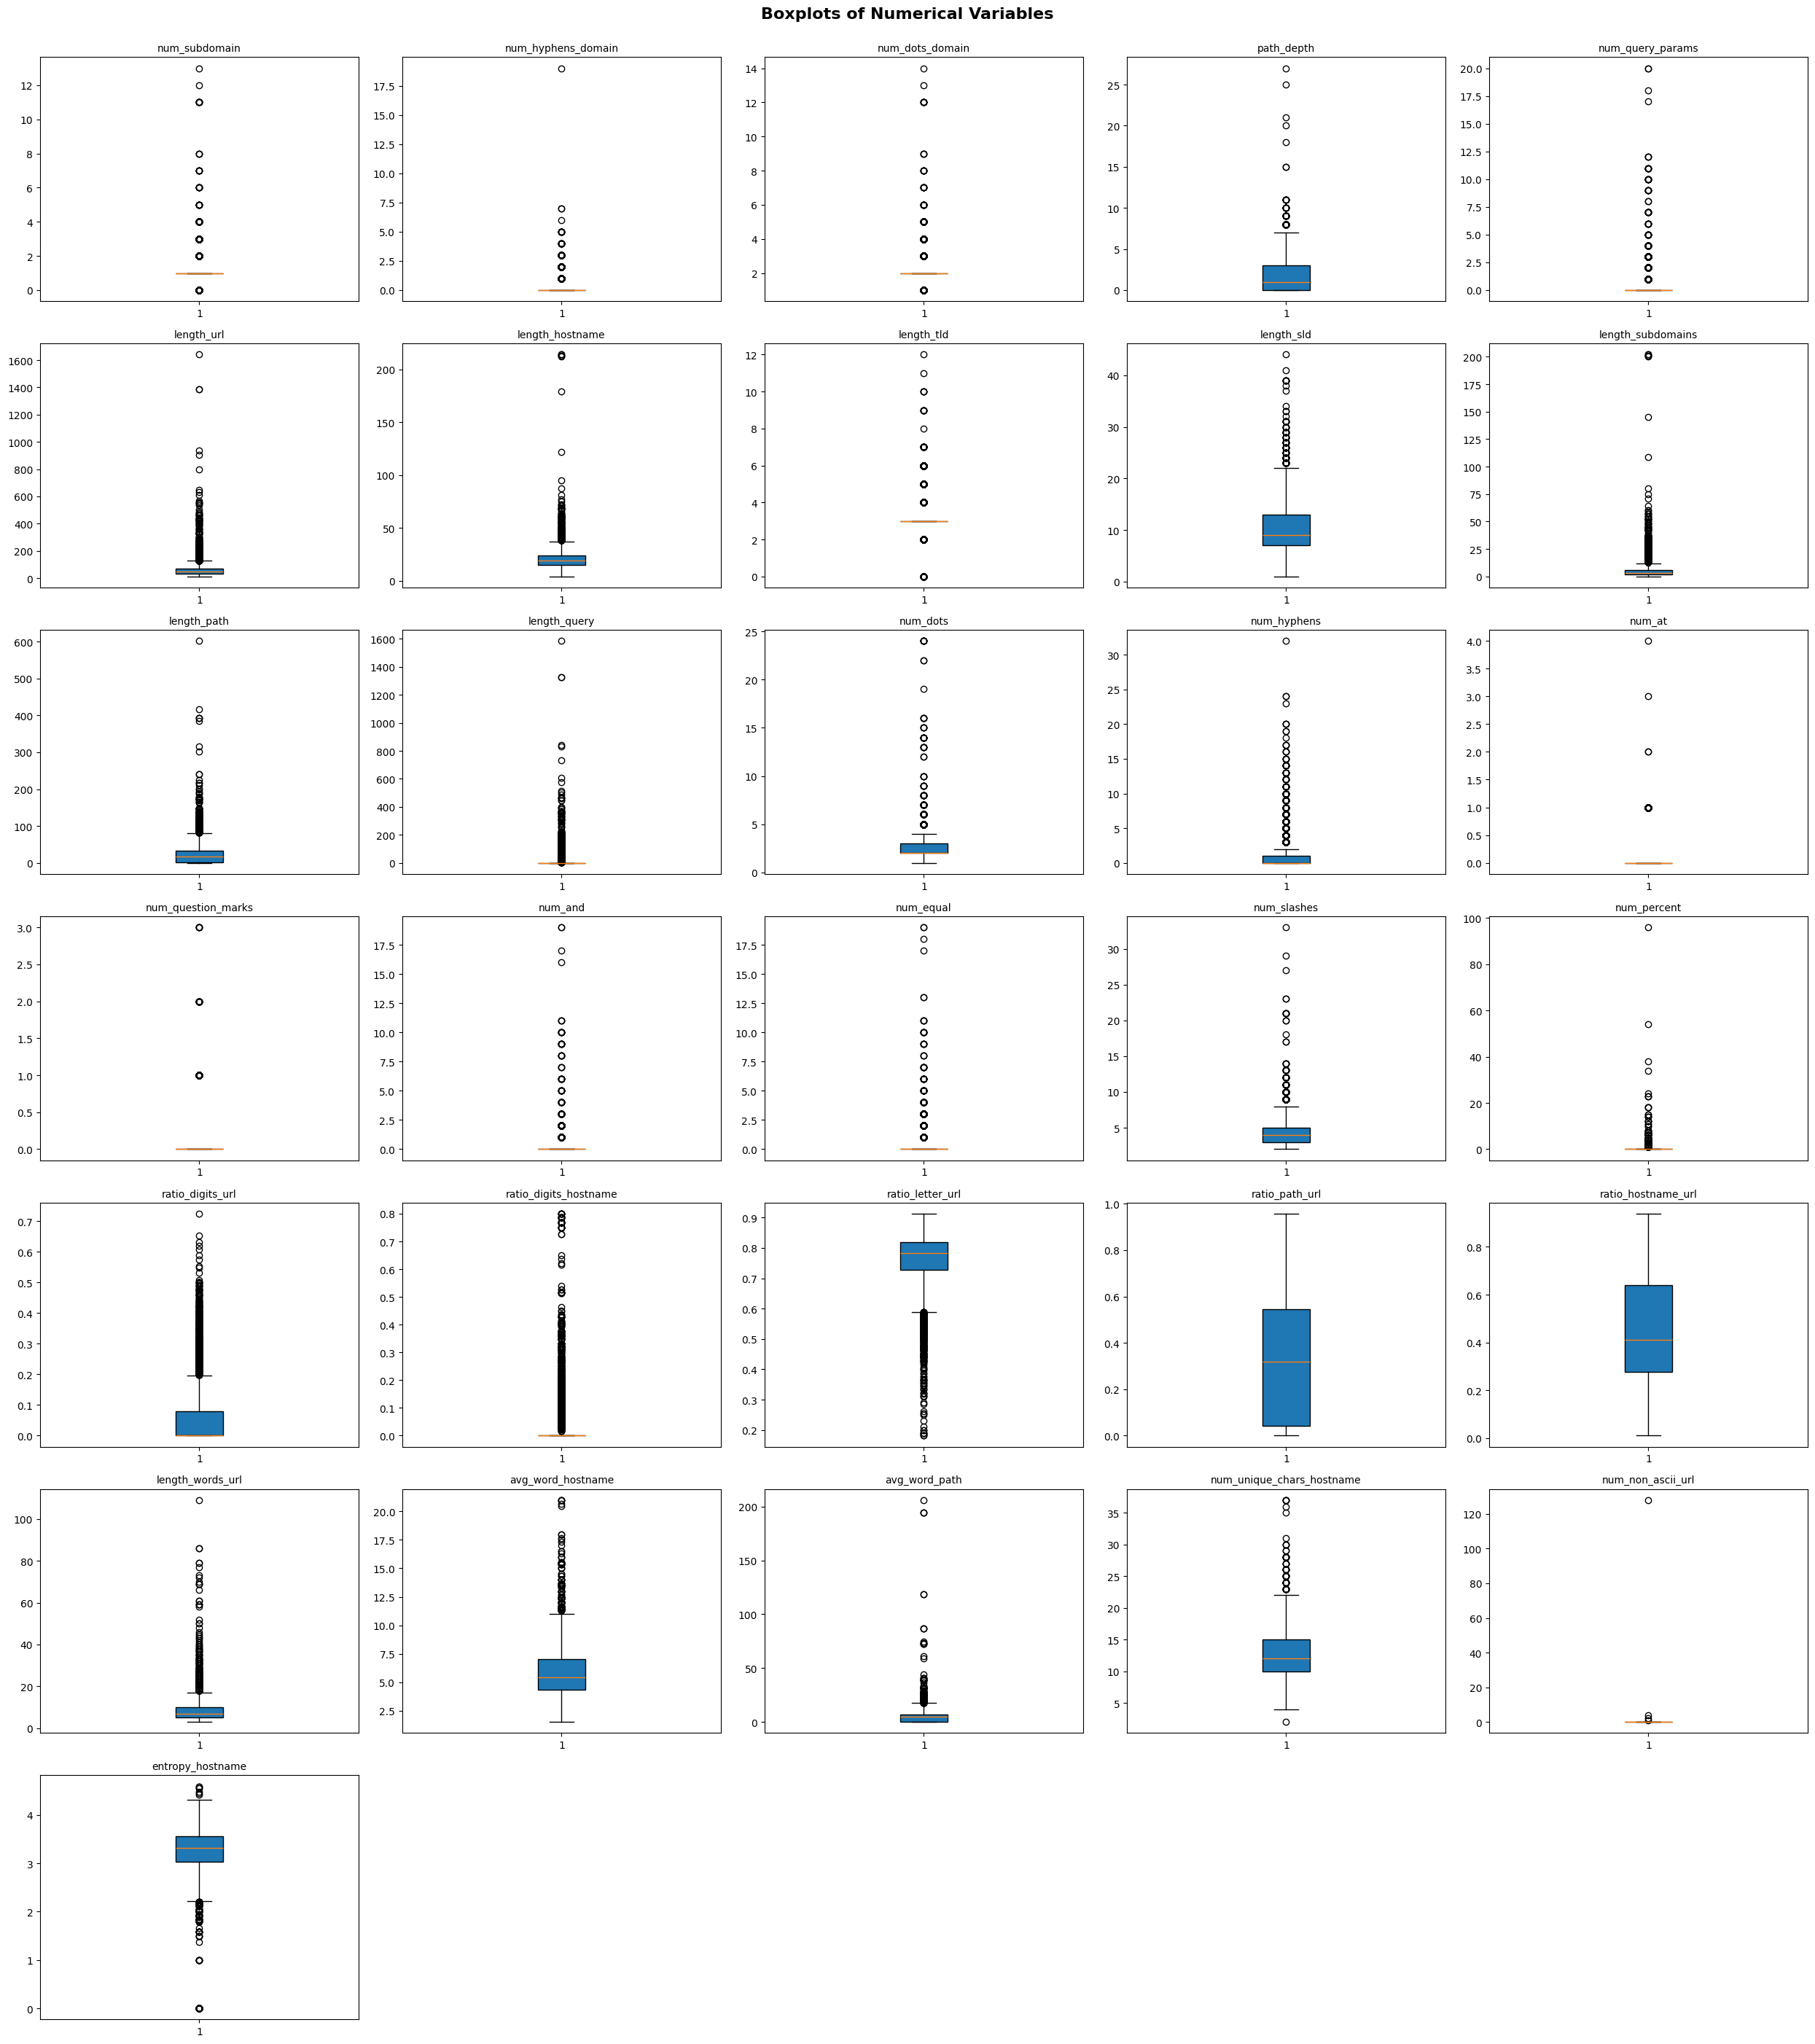

In [26]:
# plot boxplot for outlier detection
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(5 * 5, 7 * 4))
fig.suptitle('Boxplots of Numerical Variables', fontsize=16, fontweight='bold', y=1)
axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    axes[i].boxplot(df_train_sec3_temp[col].dropna(), vert=True, patch_artist=True, whis=1.5)
    axes[i].set_title(col, fontsize=10)

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.show()

Insights:
- There seems to be quite a lot of outliers for some of the columns

Plan:
- Do not remove outliers as they can contain important information
- For models like logistic regression where it is more sensitive to outliers, can use the log transformed features instead while for tree-based models, they are generally robust to outliers

#### [4.3] Descriptive Analysis for categorical / binary variables

In [27]:
# select the categorical / binary variables
categorical_variables = df_train_sec3_temp.select_dtypes(include=['bool', 'category']).columns.tolist() # exclude 'object' dtype since they are text fields

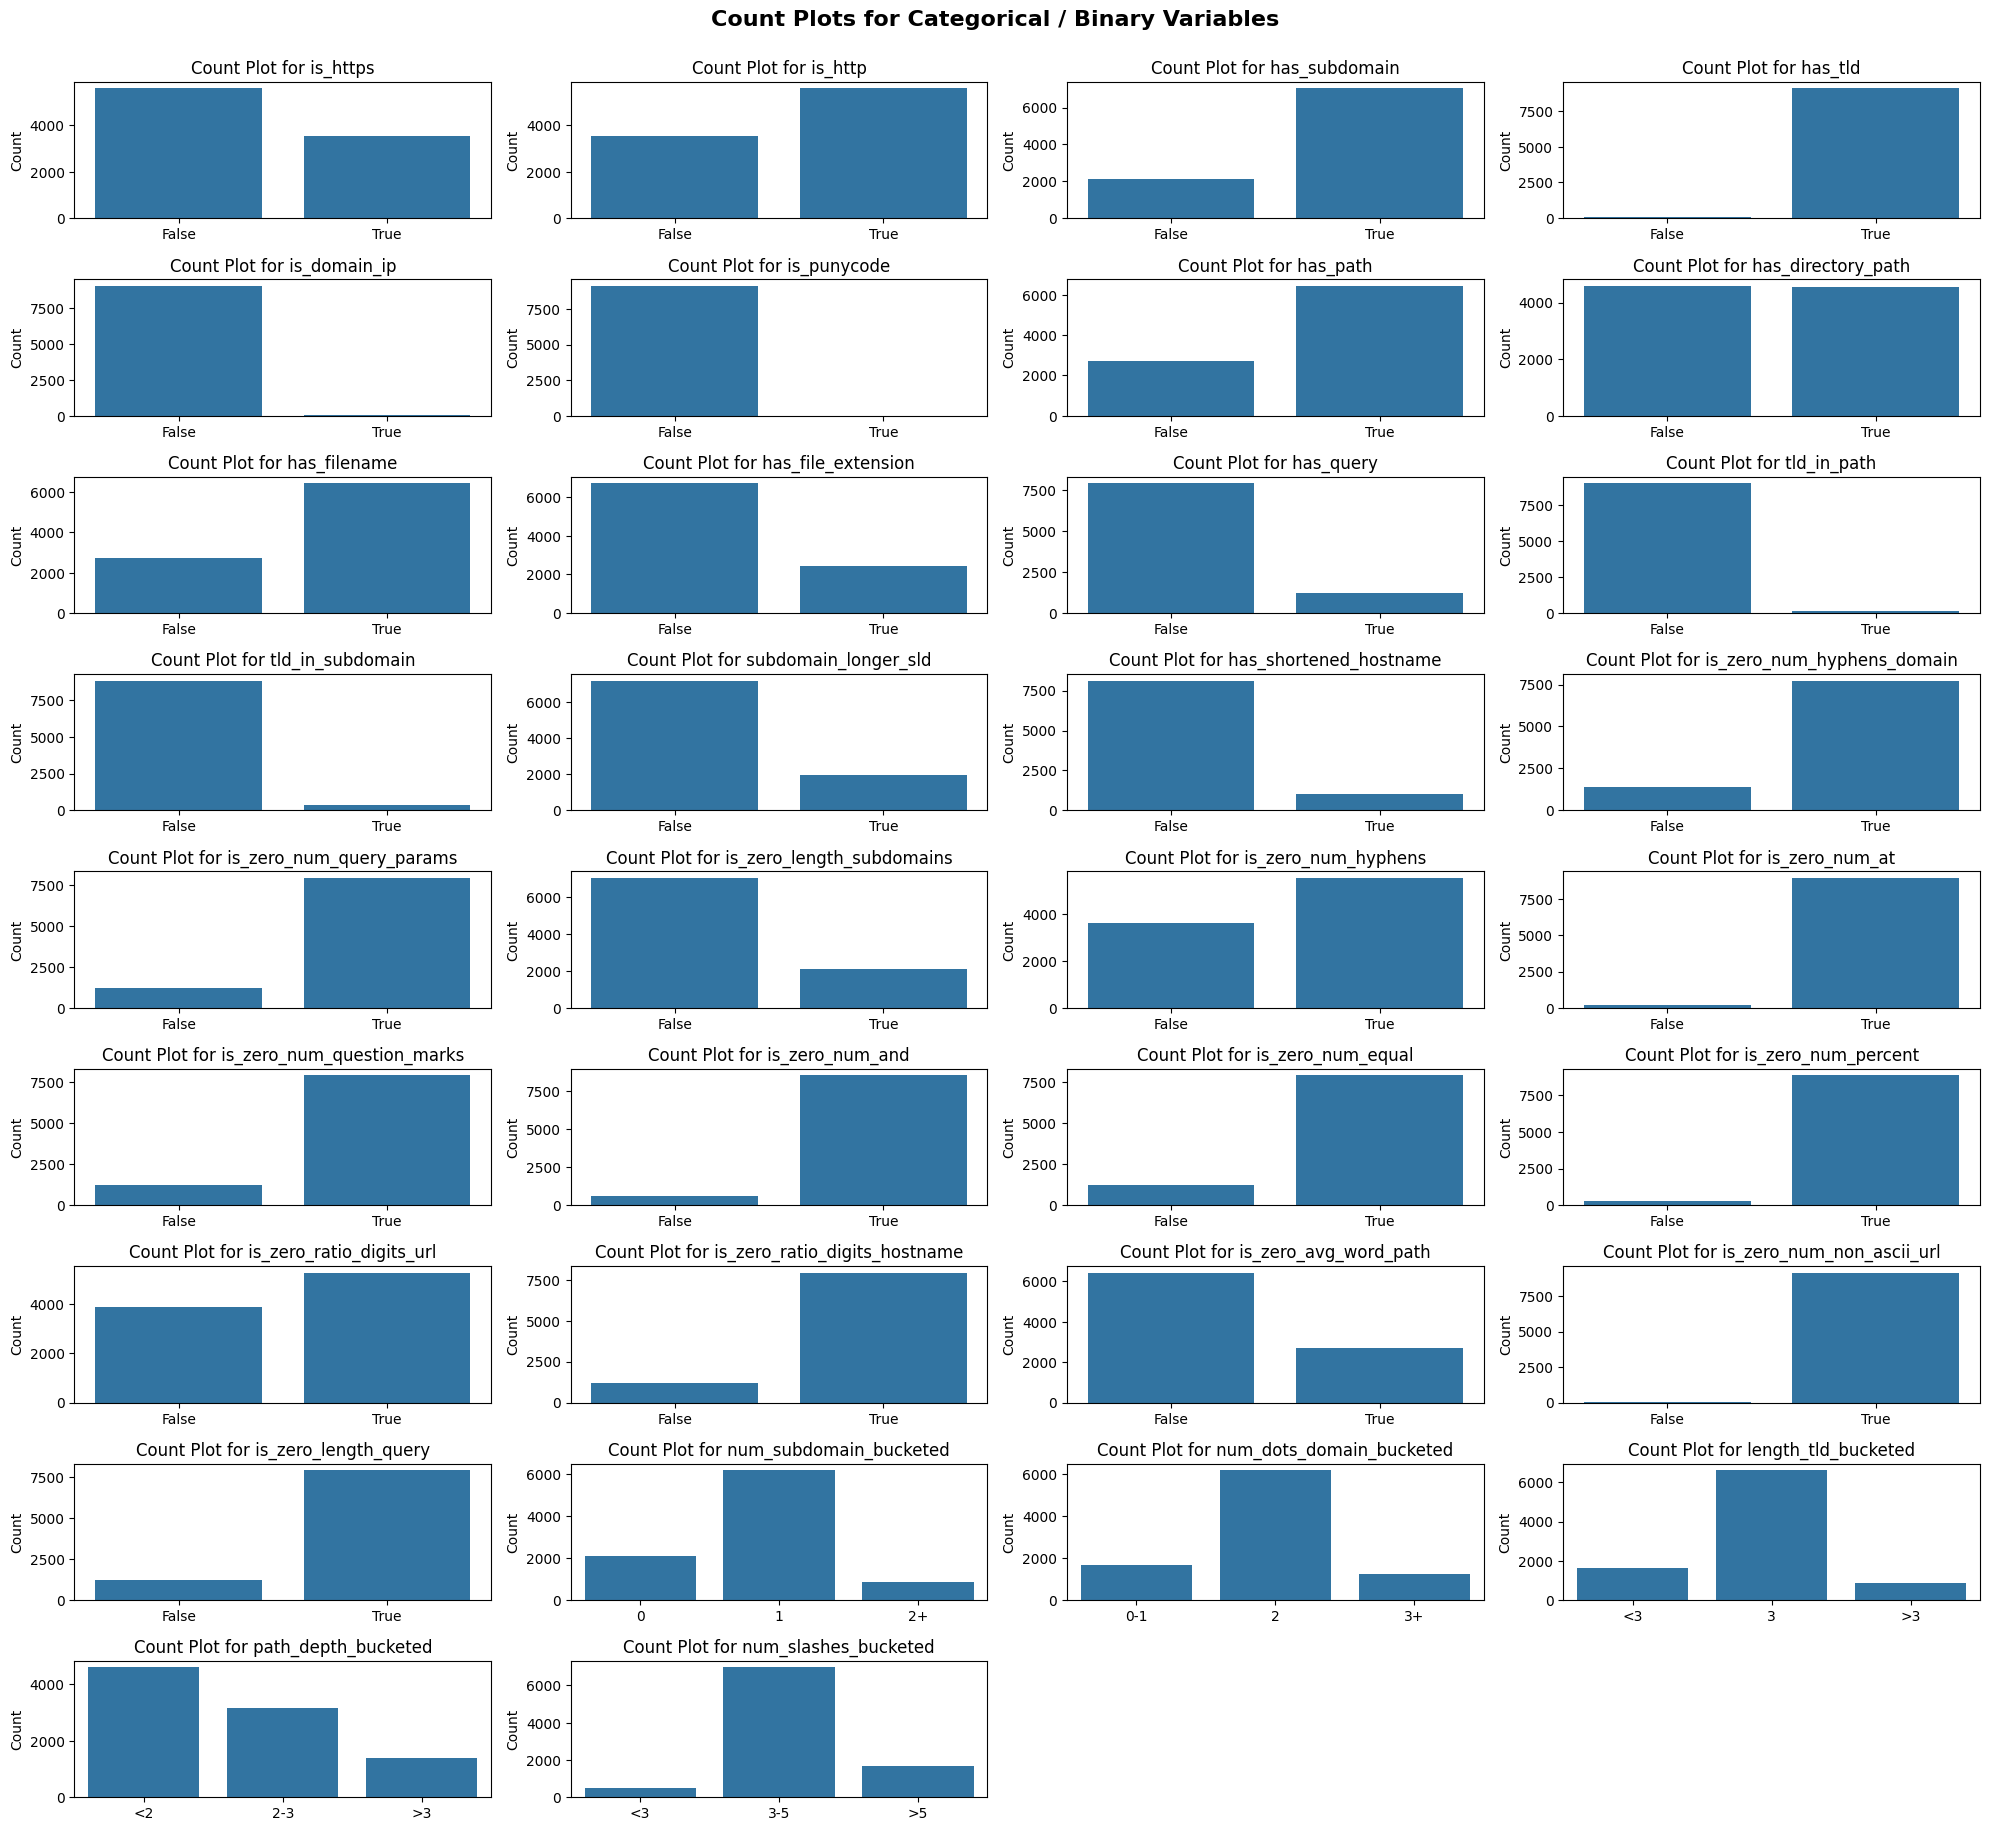

In [28]:
# plot count plots for categorical variables
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(4 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Count Plots for Categorical / Binary Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(categorical_variables):
    ax = axes[i]
    sns.countplot(data=df_train_sec3_temp, x=var_name, ax=ax)
    ax.set_title(f'Count Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
for i in range(len(categorical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

#### [4.4] Correlation Analysis - Qualitative

Skipping num_at: zero variance in at least one label group -> {0: 1, 1: 5}
Skipping num_non_ascii_url: zero variance in at least one label group -> {0: 1, 1: 5}


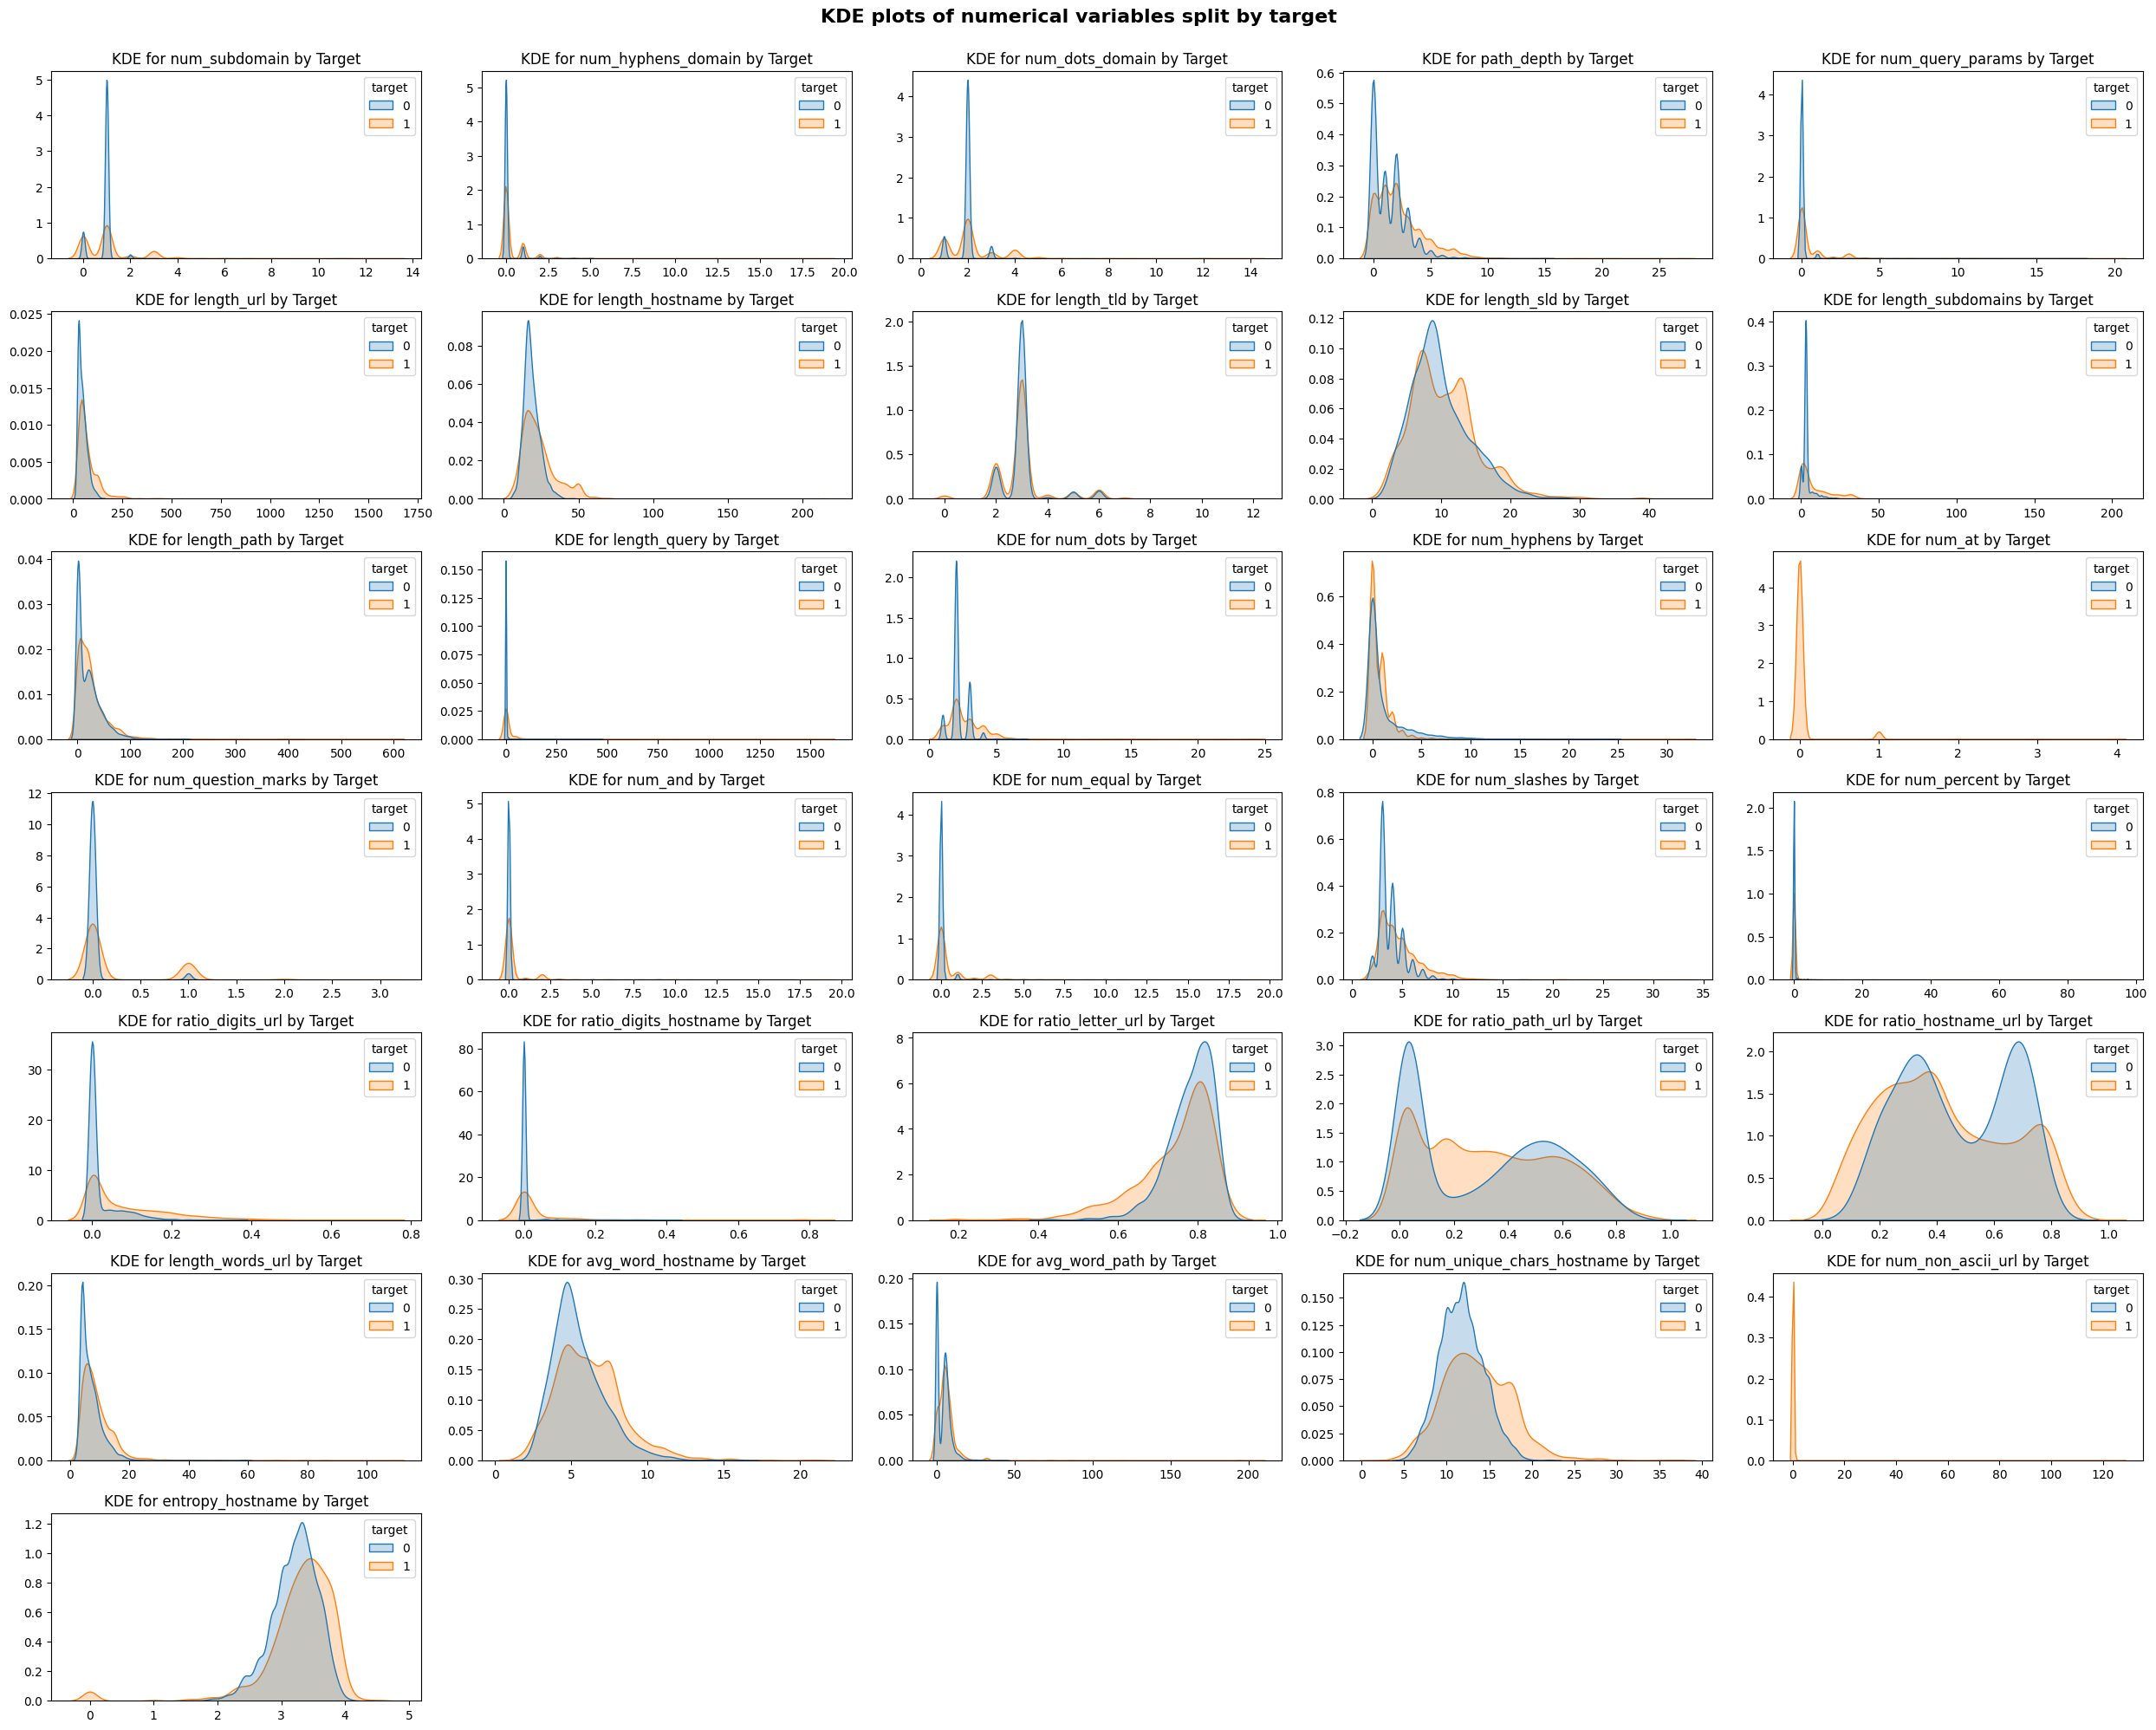

In [29]:
# plot histograms and kde for numerical variables split by label
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(5 * 5, 7 * 4))
axes = axes.flatten()
fig.suptitle('KDE plots of numerical variables split by target', fontsize=16, fontweight='bold', y=1)

for i, var_name in enumerate(numerical_variables):
    ax = axes[i]

    group_variances = df_train_sec3_temp.groupby("target")[var_name].nunique()
    if (group_variances <= 1).any():  # if any group has only 1 unique value
        print(f"Skipping {var_name}: zero variance in at least one label group -> {group_variances.to_dict()}")
        sns.kdeplot(data=df_train_sec3_temp, x=var_name, hue='target', ax=axes[i], fill=True, warn_singular=False)
        axes[i].set_title(f'Distribution of {var_name} by Target')
    else:
        sns.kdeplot(data=df_train_sec3_temp, x=var_name, hue='target', ax=axes[i], fill=True, common_norm=False)
        axes[i].set_title(f'Distribution of {var_name} by Target')
    
    ax.set_title(f'KDE for {var_name} by Target')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Insights:
- `num_at`, `num_non_ascii_url` only have 1 unique value in the target class 0. 
- There are some predictors with good difference in distribution bteween target class

Plan:
- For the features with no variance in one of the group, this potentially suggests that these are very good features with strong predictive signals and this is unlikely due to data leakage, thus we can keep them

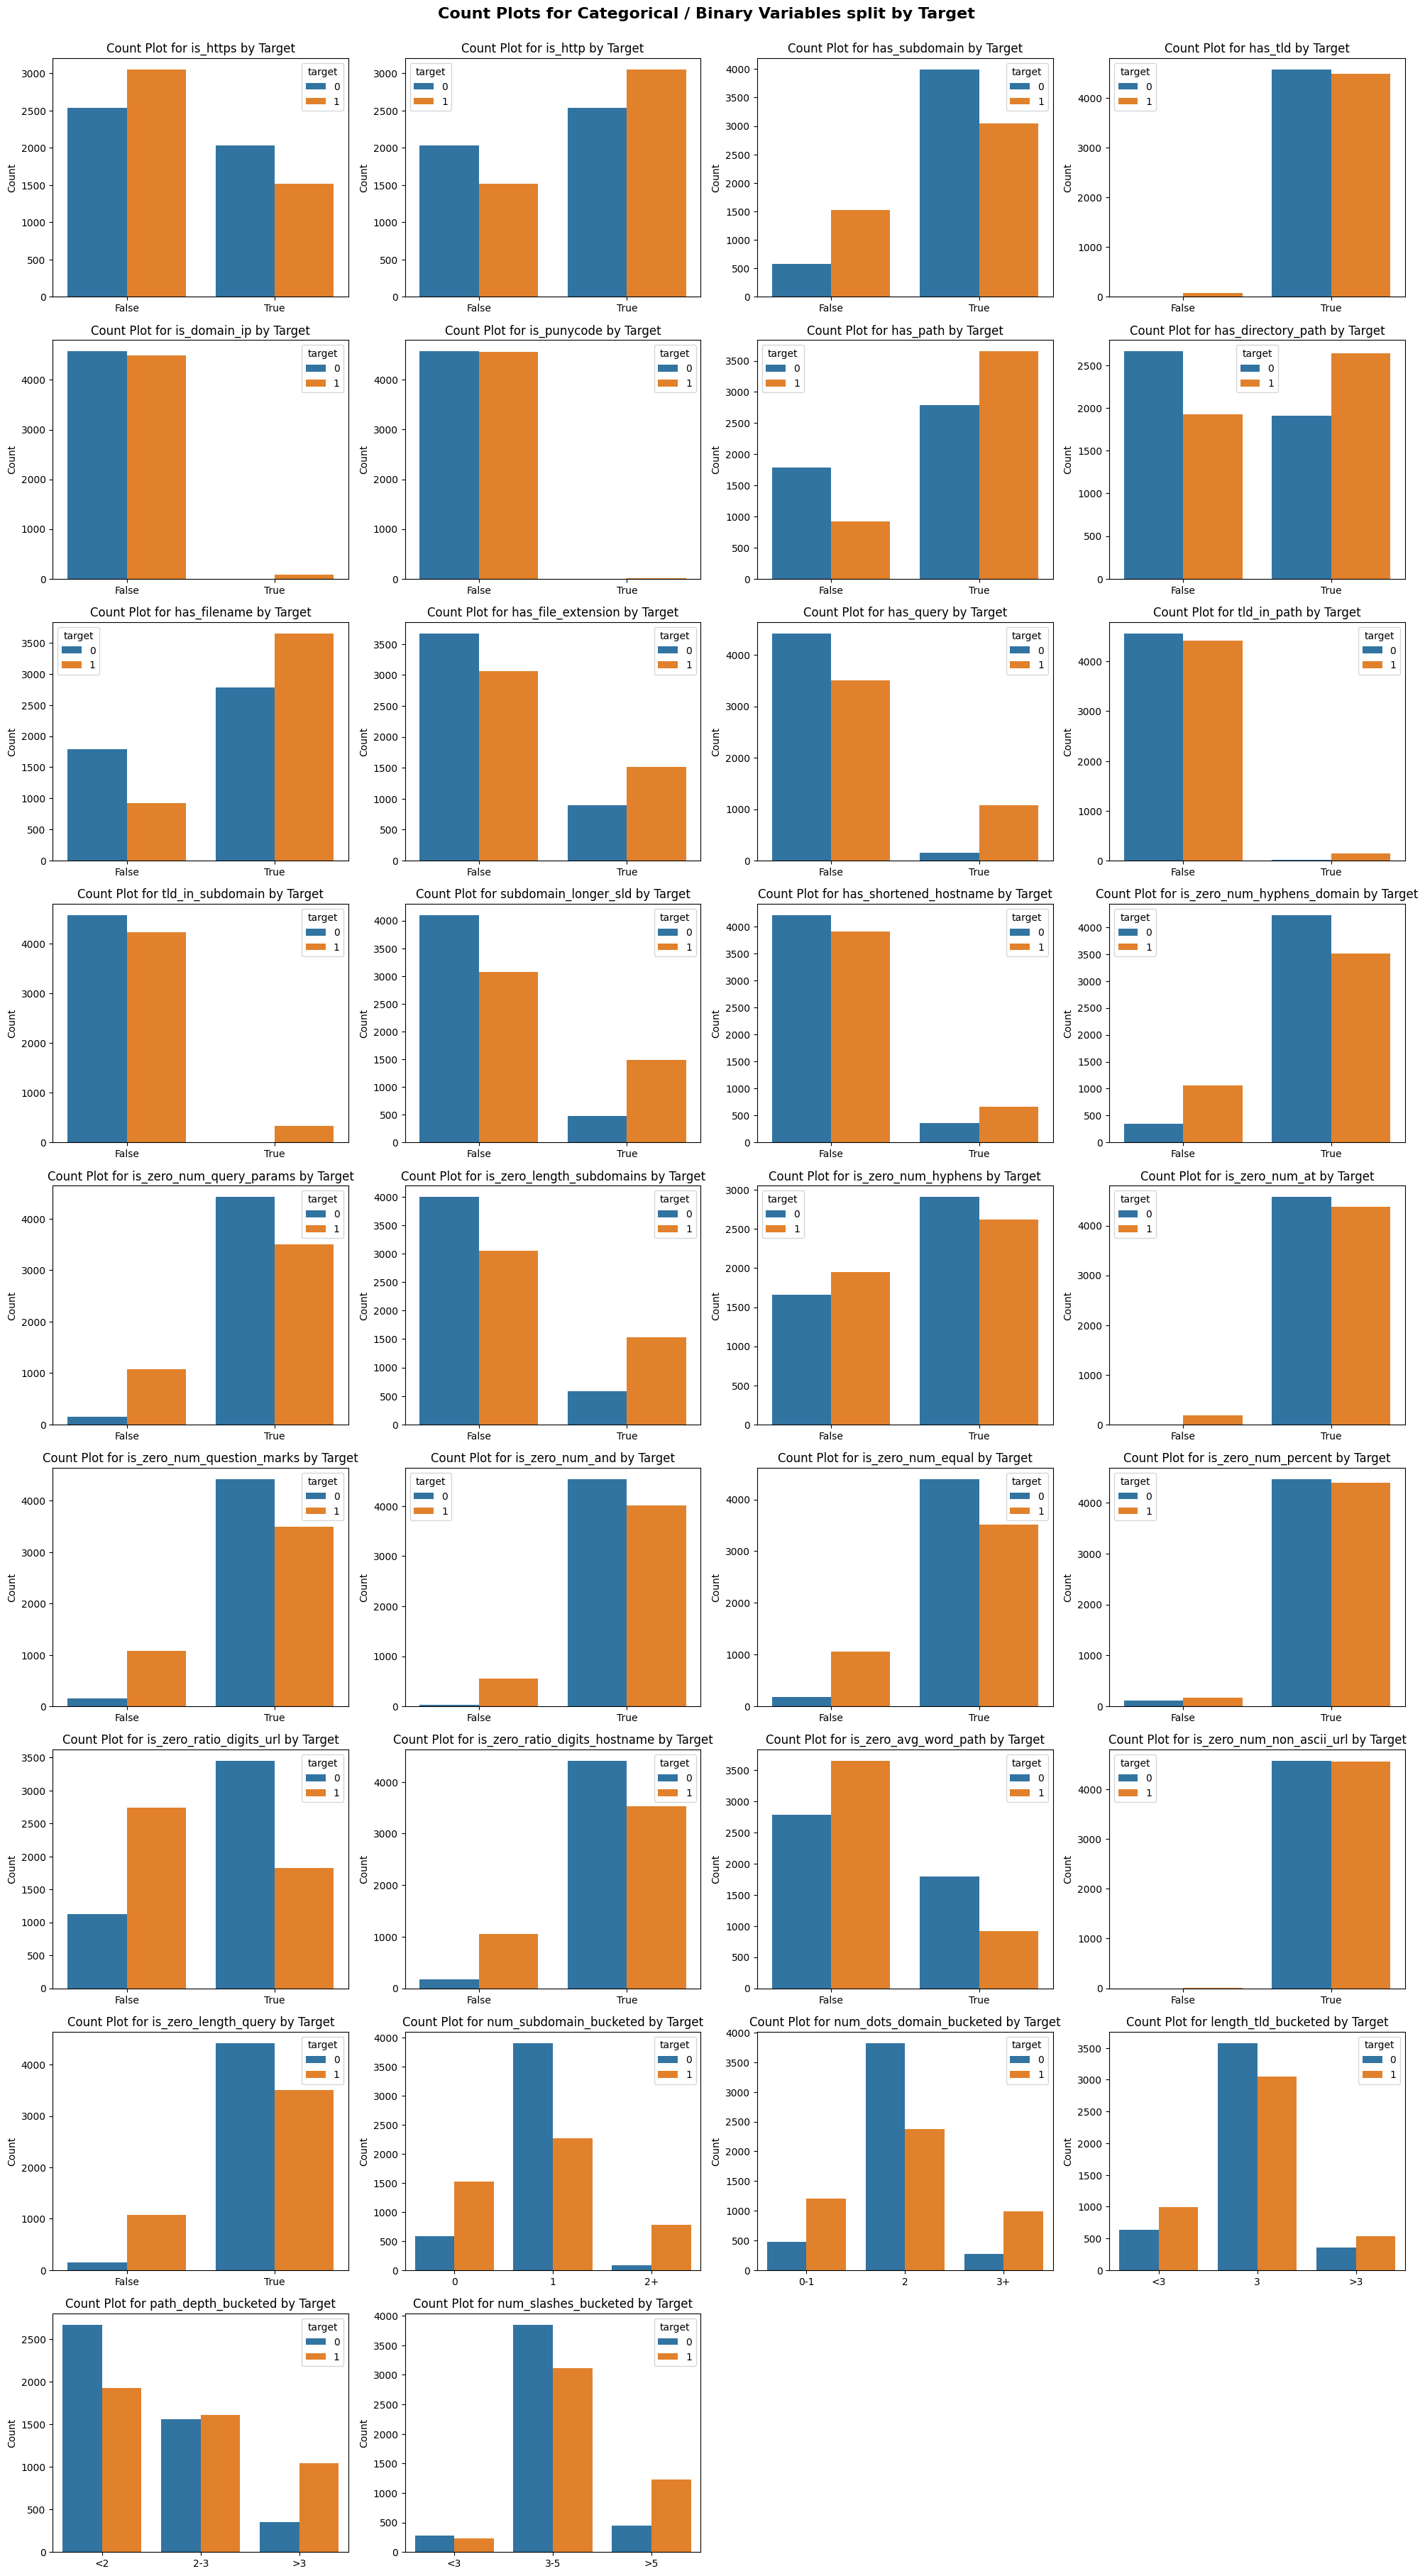

In [31]:
# plot count plot for categorical variables split by label
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(4 * 5, 5 * 8))
axes = axes.flatten()
fig.suptitle('Count Plots for Categorical / Binary Variables split by Target', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(categorical_variables):
    ax = axes[i]
    sns.countplot(data=df_train_sec3_temp, x=var_name, hue='target', ax=ax)
    ax.set_title(f'Count Plot for {var_name} by Target')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
for i in range(len(categorical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()


In [32]:
# print out columns where there is only 1 unique label in either group
for col in categorical_variables:
    group_variances = df_train_sec3_temp.groupby("target")[col].nunique()
    if (group_variances <= 1).any(): 
        print(f"{col}: zero variance in at least one group -> {group_variances.to_dict()}")

has_tld: zero variance in at least one group -> {0: 1, 1: 2}
is_domain_ip: zero variance in at least one group -> {0: 1, 1: 2}
tld_in_subdomain: zero variance in at least one group -> {0: 1, 1: 2}
is_zero_num_at: zero variance in at least one group -> {0: 1, 1: 2}
is_zero_num_non_ascii_url: zero variance in at least one group -> {0: 1, 1: 2}


Insights:
- Similar to the case for numerical, these variables with no variance in at least one group shows that they are strong predictors. These variables makes sense and unlikely to be due to data leakage

#### [4.5] Correlation Analysis - Quantitative

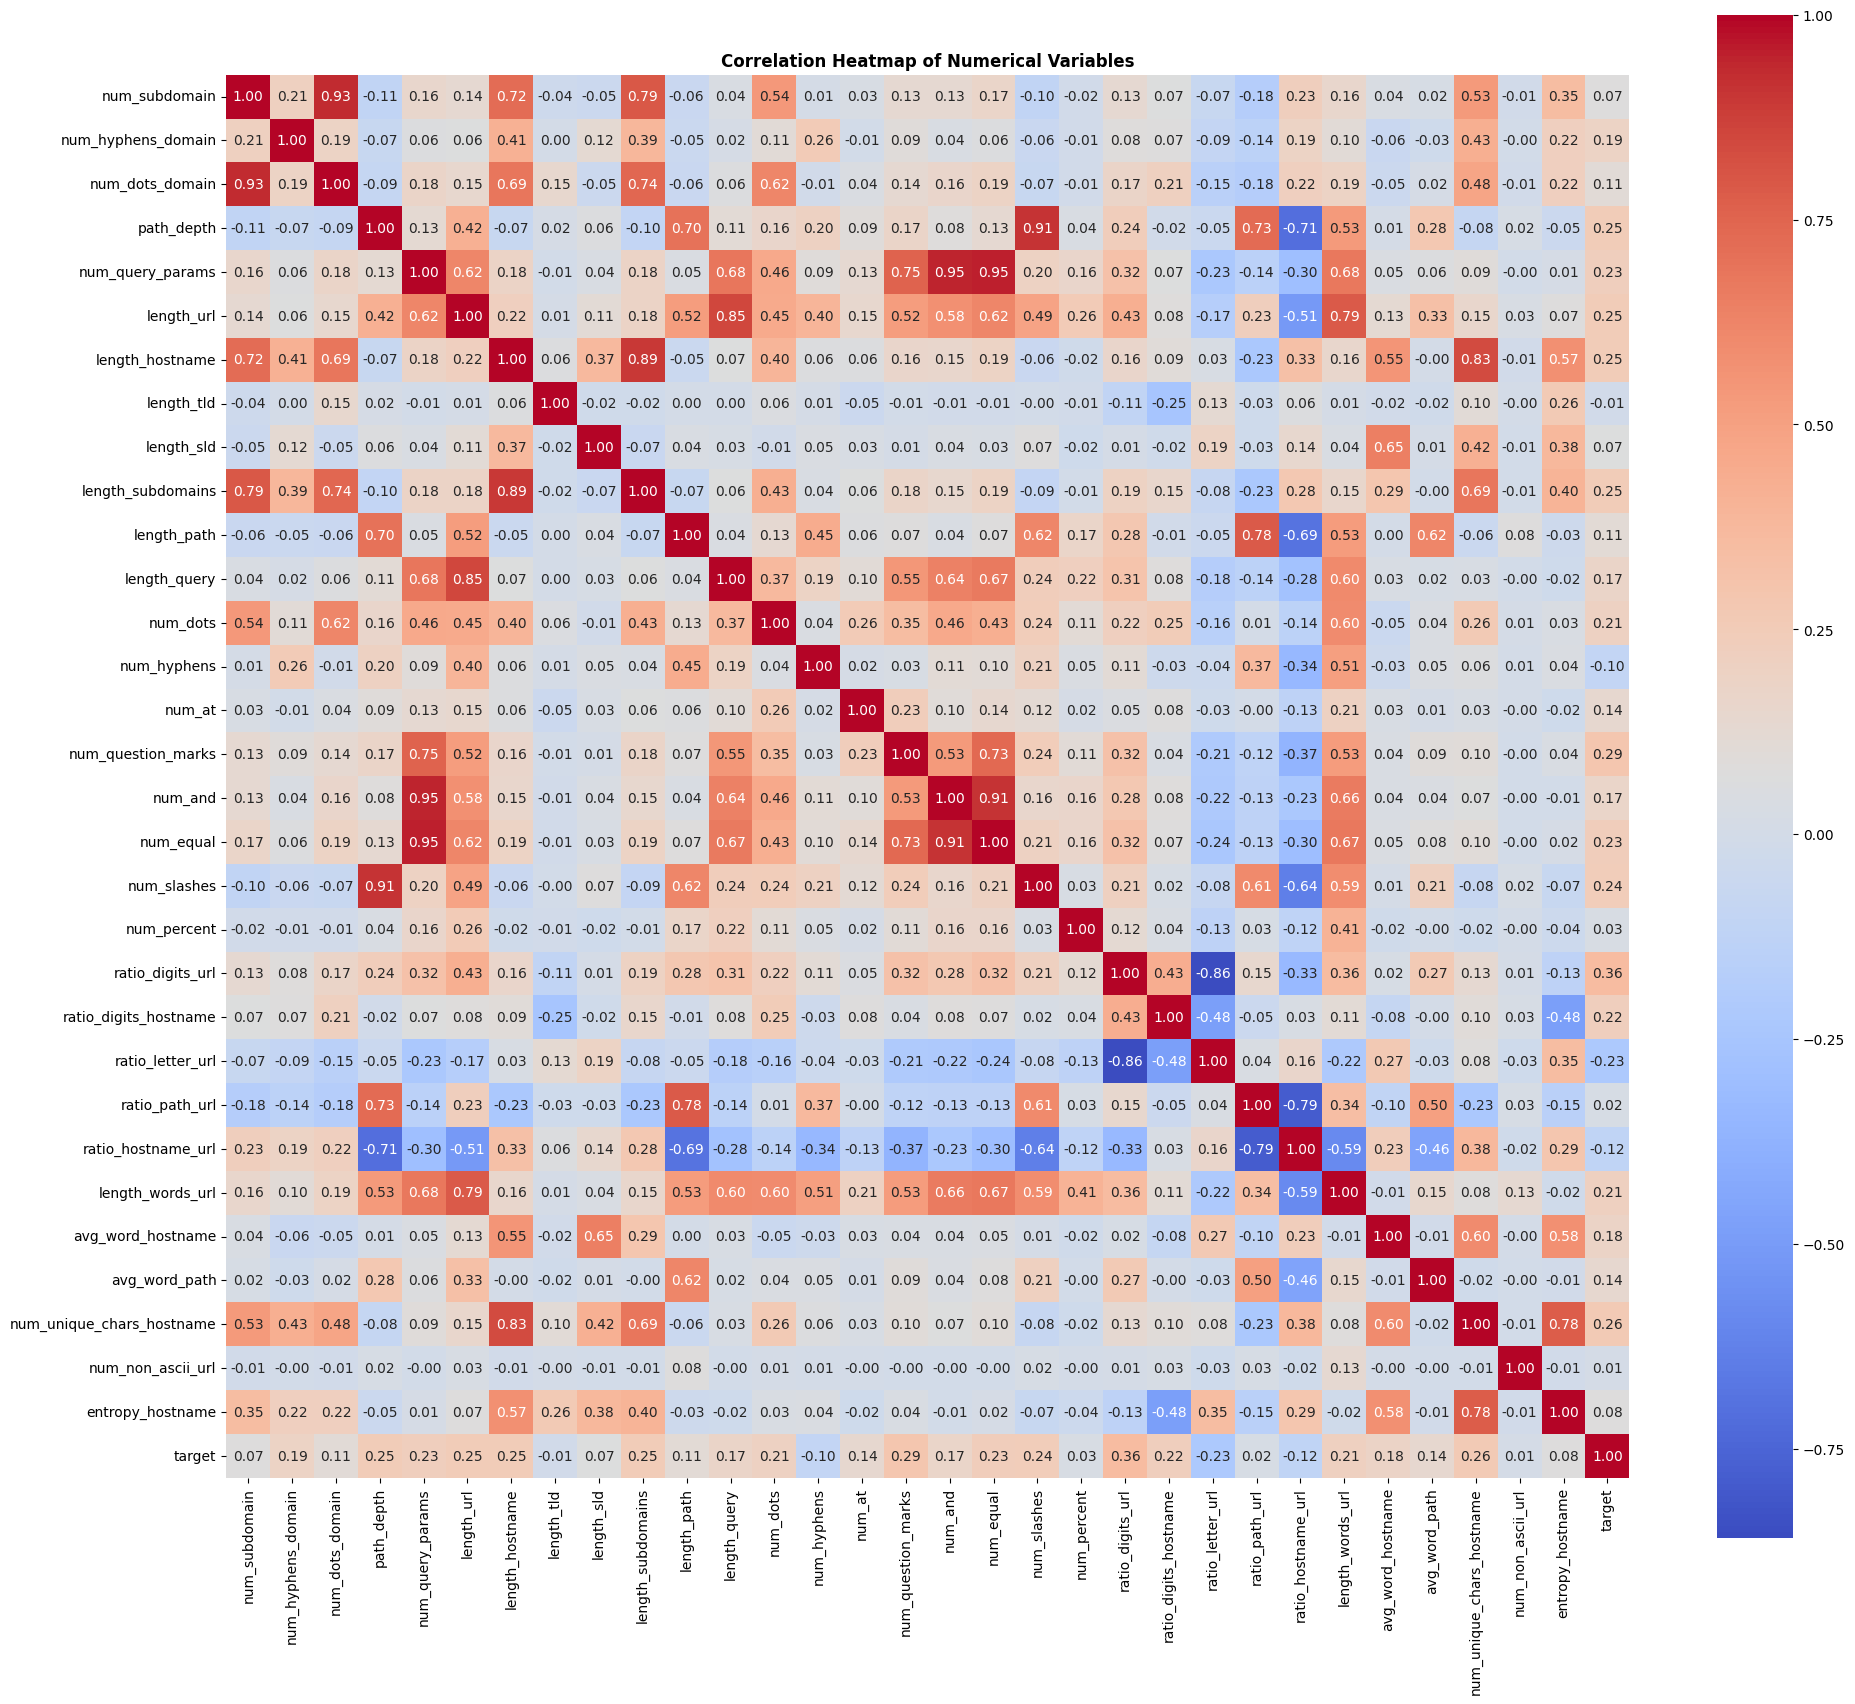

In [33]:
# pairwise correlation heatmap for numerical variables
plt.figure(figsize=(20, 20))
corr = df_train_sec3_temp[numerical_variables + ['target']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Insights:
- No feature highly correlated with target thus likely no data leakage
- `num_dots_domain` and `num_subdomain` highly correlated (0.93)
- `num_slashes` and `path_depth` highly correlated (0.91)
- `num_and` and `num_query_params` highly correlated (0.95)
- `num_equal` and `num_query_params` highly correlated (0.95)

Plan:
- For the features that are highly correlated with each other, this can introduce multicollinearity which will impact model's performance
    - For logistic regression, will have to remove one of the variables since multicollinearity affects linear models
    - For tree-based model, we can leave it as it is unaffected by multicollinearity
    - For deep learning, it is a good idea to remove it to improve speed of model training.
- Remove `num_query_params`, `num_slashes`, `num_dots_domain`

In [34]:
# compute information gain for categorical / boolean variables
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    probabilities = counts / len(x)
    return -np.sum(probabilities * np.log2(probabilities))


def conditional_entropy(x, y):
    y_values, y_counts = np.unique(y, return_counts=True)
    y_probabilities = y_counts / len(y)

    conditional_entropies = []
    for y_val, y_prob in zip(y_values, y_probabilities):
        x_given_y = x[y == y_val]
        conditional_entropies.append(entropy(x_given_y))

    return np.sum(y_probabilities * conditional_entropies)

# compute Entropy
categorical_variables_plus_label = categorical_variables + ['target']
entropies = pd.DataFrame([(x, entropy(df_train_sec3_temp[x])) for x in categorical_variables_plus_label], columns=['cat1', 'H(cat1)'])

# compute Conditional Entropy
results = []
for cat1 in categorical_variables_plus_label:
    for cat2 in categorical_variables_plus_label:
        if cat1 != cat2:
            results.append((cat1, cat2, conditional_entropy(df_train_sec3_temp[cat1], df_train_sec3_temp[cat2])))

conditional_entropy_df = pd.DataFrame(results, columns=['cat1', 'cat2', 'H(cat1|cat2)'])

information_gain = entropies.merge(conditional_entropy_df)
information_gain['information gain'] = information_gain['H(cat1)'] - information_gain['H(cat1|cat2)']

information_gain

cat1   H(cat1)                      cat2  H(cat1|cat2)  \
0     is_https  0.964035                   is_http      0.000000   
1     is_https  0.964035             has_subdomain      0.952284   
2     is_https  0.964035                   has_tld      0.957784   
3     is_https  0.964035              is_domain_ip      0.957784   
4     is_https  0.964035               is_punycode      0.964033   
...        ...       ...                       ...           ...   
1185    target  1.000000    num_subdomain_bucketed      0.880051   
1186    target  1.000000  num_dots_domain_bucketed      0.912580   
1187    target  1.000000       length_tld_bucketed      0.987845   
1188    target  1.000000       path_depth_bucketed      0.961861   
1189    target  1.000000      num_slashes_bucketed      0.963619   

      information gain  
0             0.964035  
1             0.011752  
2             0.006251  
3             0.006251  
4             0.000002  
...                ...  
1185          0.119949  
1186          0.087420  
1187          0.012155  
1188          0.038139  
1189          0.036381  

[1190 rows x 5 columns]

/var/folders/70/_fptq3sn5mldlj0fhy1pvyh40000gn/T/ipykernel_79668/3048015830.py:1: FutureWarning: The provided callable <function sum at 0x1073e7420> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  information_gain.pivot_table(values='information gain', index='cat1', columns='cat2', aggfunc=np.sum)
/var/folders/70/_fptq3sn5mldlj0fhy1pvyh40000gn/T/ipykernel_79668/3048015830.py:4: FutureWarning: The provided callable <function sum at 0x1073e7420> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2),


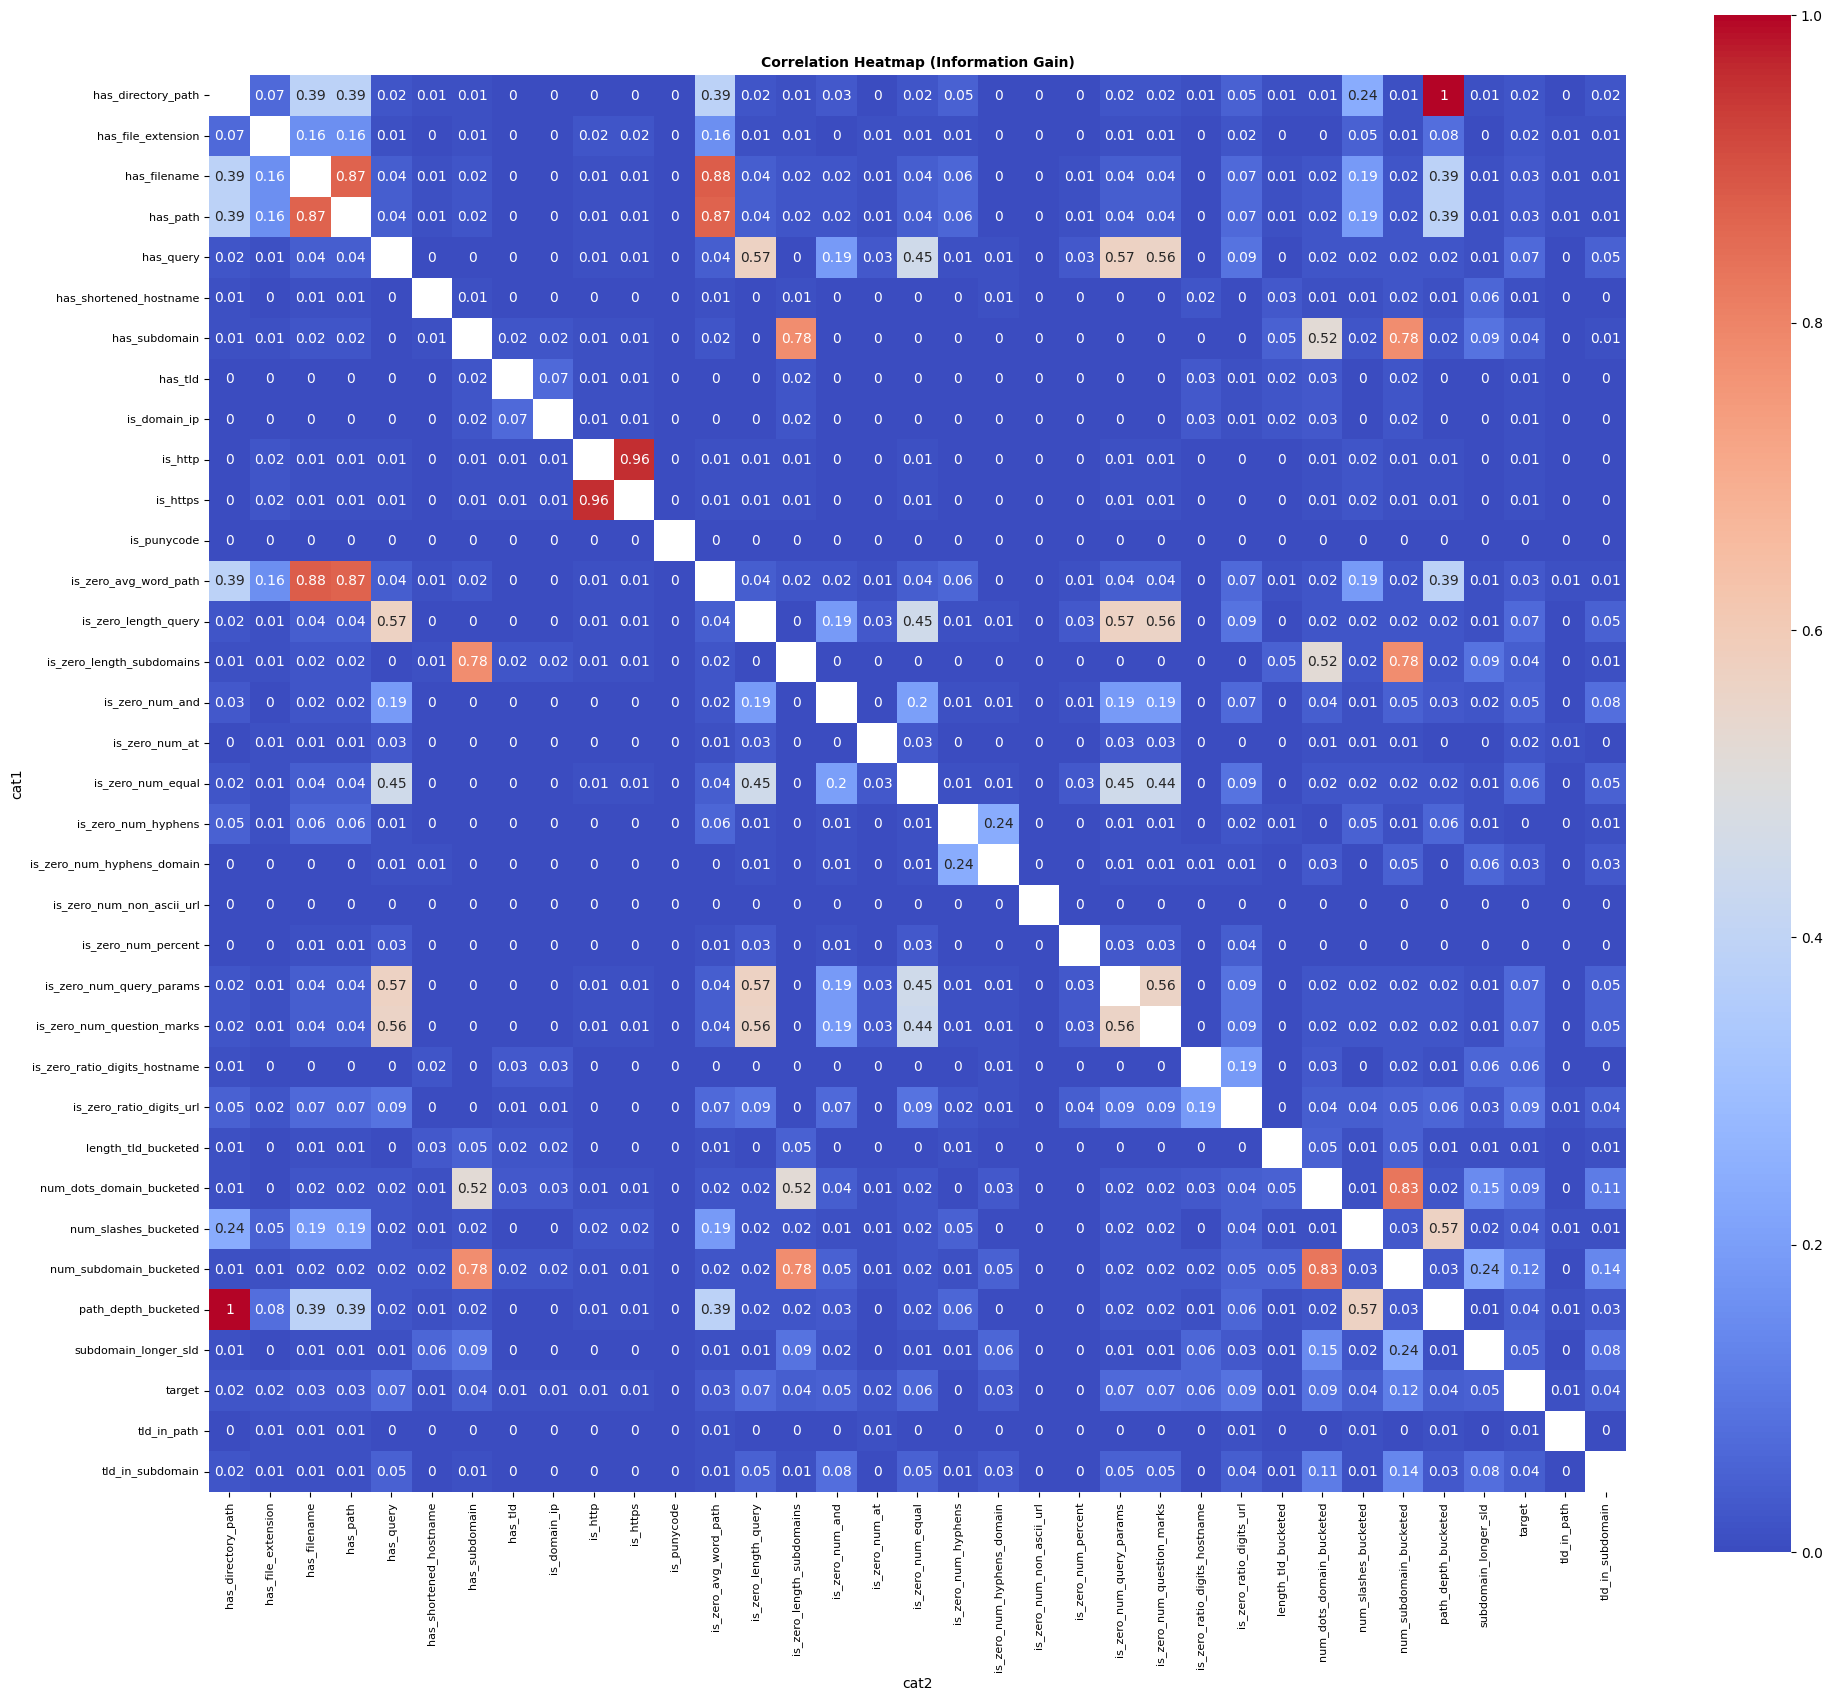

In [35]:
information_gain.pivot_table(values='information gain', index='cat1', columns='cat2', aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(20,20))

hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2),
                 ax=ax, cmap='coolwarm', annot=True, square=True, cbar_kws={"shrink": .8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
t = ax.set_title('Correlation Heatmap (Information Gain)', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Insights:
- `is_https` and `is_http` highly correlated (0.96)
- `path_depth_bucketed` and `has_directory_path` highly correlated (1)

Plan:
- Remove `is_https` and `has_directory_path`

In [36]:
# statistical test (t-test) to check if there are any statistically significant differences in means between two target groups (label = 0 and label = 1)
results = []

alpha = 0.05  

for feature in numerical_variables:
    group0 = df_train_sec3_temp[df_train_sec3_temp.target == 0][feature]
    group1 = df_train_sec3_temp[df_train_sec3_temp.target == 1][feature]

    _, p_value = stats.ttest_ind(group0, group1, equal_var=False)
    results.append((feature, p_value))

t_test_df = pd.DataFrame(results, columns=['Feature', 'P-value'])
t_test_df['Reject_H0'] = t_test_df['P-value'] < alpha
t_test_df = t_test_df.sort_values('P-value')
t_test_df


Feature        P-value  Reject_H0
20           ratio_digits_url  5.340360e-268       True
15         num_question_marks  4.219996e-176       True
28  num_unique_chars_hostname  6.904033e-140       True
9           length_subdomains  4.177789e-129       True
3                  path_depth  2.383030e-127       True
6             length_hostname  7.344708e-125       True
5                  length_url  3.822996e-123       True
18                num_slashes  3.229166e-122       True
17                  num_equal  2.874716e-110       True
4            num_query_params  1.367700e-108       True
22           ratio_letter_url  2.490864e-106       True
21      ratio_digits_hostname  1.211026e-102       True
25           length_words_url   2.751081e-91       True
12                   num_dots   1.230617e-86       True
1          num_hyphens_domain   1.120276e-75       True
26          avg_word_hostname   5.225039e-68       True
11               length_query   1.226657e-61       True
16                    num_and   1.033920e-59       True
27              avg_word_path   1.253961e-42       True
14                     num_at   9.704184e-41       True
24         ratio_hostname_url   7.425135e-29       True
10                length_path   7.719308e-26       True
2             num_dots_domain   4.199732e-24       True
13                num_hyphens   2.919262e-22       True
30           entropy_hostname   2.210234e-13       True
0               num_subdomain   2.269480e-12       True
8                  length_sld   3.019280e-10       True
19                num_percent   8.069980e-03       True
23             ratio_path_url   2.744466e-02       True
7                  length_tld   2.071728e-01      False
29          num_non_ascii_url   2.919272e-01      False

Insights:
- `length_tld` and `num_non_ascii_url` have p-value > 0.05, thus suggesting that there is insignificant difference in means between both group (label = 0 and label = 1) and is likely to not be informative as features. 

Plan:
- Remove `num_non_ascii_url` as a feature. But we believe that `length_tld` will be a significant feature in detecting phishing links as common (and as such higher chance of being valid) tld tend to have a length of 3, thus it will be kept

In [37]:
# statistical test (chi square test) and check if there are any statistically significant associations between categorical variables and label
alpha = 0.05  
results = []

for feature in categorical_variables:
    contingency_table = pd.crosstab(df_train_sec3_temp[feature], df_train_sec3_temp['target'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    reject_h0 = p < alpha  
    results.append((feature, chi2, dof, p, reject_h0))

chi2_df = pd.DataFrame(results, columns=['Feature', 'Chi2', 'DoF', 'P-value', 'Reject_H0']).sort_values('P-value')

chi2_df


Feature         Chi2  DoF        P-value  Reject_H0
29         num_subdomain_bucketed  1415.232484    2  4.854794e-308       True
24       is_zero_ratio_digits_url  1172.430000    1  5.985317e-257       True
30       num_dots_domain_bucketed  1068.306517    2  1.047580e-232       True
20     is_zero_num_question_marks   799.423351    1  7.201700e-176       True
16       is_zero_num_query_params   795.699350    1  4.646254e-175       True
28           is_zero_length_query   795.699350    1  4.646254e-175       True
10                      has_query   795.699350    1  4.646254e-175       True
25  is_zero_ratio_digits_hostname   735.267391    1  6.409785e-162       True
22              is_zero_num_equal   727.662282    1  2.887509e-160       True
13           subdomain_longer_sld   665.797255    1  8.195629e-147       True
2                   has_subdomain   550.845143    1  8.243991e-122       True
17      is_zero_length_subdomains   550.845143    1  8.243991e-122       True
21                is_zero_num_and   496.378599    1  5.833372e-110       True
32            path_depth_bucketed   466.820947    2  4.276803e-102       True
33           num_slashes_bucketed   446.364675    2   1.183430e-97       True
15     is_zero_num_hyphens_domain   414.593771    1   3.666012e-92       True
8                    has_filename   393.955422    1   1.139694e-87       True
26          is_zero_avg_word_path   392.962861    1   1.874412e-87       True
6                        has_path   392.475359    1   2.393277e-87       True
12               tld_in_subdomain   351.134723    1   2.399047e-78       True
7              has_directory_path   239.249892    1   5.731439e-54       True
9              has_file_extension   211.054041    1   8.089221e-48       True
19                 is_zero_num_at   189.952057    1   3.256836e-43       True
31            length_tld_bucketed   153.189486    2   5.436579e-34       True
11                    tld_in_path   124.466116    1   6.660688e-29       True
1                         is_http   122.359409    1   1.925900e-28       True
0                        is_https   122.359409    1   1.925900e-28       True
14         has_shortened_hostname    97.006474    1   6.910103e-23       True
4                    is_domain_ip    78.718560    1   7.161955e-19       True
3                         has_tld    78.718560    1   7.161955e-19       True
18            is_zero_num_hyphens    36.755460    1   1.339150e-09       True
23            is_zero_num_percent    14.536609    1   1.374622e-04       True
5                     is_punycode     5.826942    1   1.578253e-02       True
27      is_zero_num_non_ascii_url     2.251641    1   1.334728e-01      False

Insights:
- `is_zero_num_non_ascii_url` have p-value > 0.05 suggesting that the categorical features have a statistically insignificant association with the target

Plan:
- Remove `is_zero_num_non_ascii_url`

#### [4.6] Descriptive Analysis for textual features

In [38]:
# select the categorical / binary variables
text_variables = df_train_sec3.select_dtypes(include=['object']).columns.tolist()

Plan:
- From the text variables, we can try to extract features for the common tld, file_extension. For the rest of the fields, relevant info has been extracted or there is too many unique values with no patterns

In [40]:
df_train_sec3

url  \
0     http://cafecitoperez.ivanidzakovic.com/admin/aociufd/goodl.vci/e6edcebab88867a2f99a346ebaaf8179/view/login.php?cmd=login_submit&amp;id=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59&amp;session=f7d4a85c3588b5be032bea66d54f3a59f7d4a85c3588b5be032bea66d54f3a59   
1                                                                                                                                                                                                                                                          https://www.guiadoexcel.com.br/   
2                                                                       https://www.mysummercamps.com/forum/For_Camp_Directors_C3/Research_and_Learn_F10/Bridging_the_gap_at_summer_camp/gforum.cgi?url=http://server.bludomain82.com/~bree2/review/#_&amp;?hannah.judge@discsystems.co.uk   
3                                                                                                                                                                                                                                                           https://www.health-island.net/   
4                                                                                                                                                                                                                                              https://www.youtube.com/watch?v=0jqwikTk9gw   
...                                                                                                                                                                                                                                                                                    ...   
9138                                                                                                                                                                                                                                                   http://rebrand.ly/App_novo_cadastro   
9139                                                                                                                                                                                                                                                        http://whattsapp2020.ygto.com/   
9140                                                                                                                                                                                                                                      http://www.ezblox.site/free/jennifer111/helpdesk   
9141                                                                                                                                                                           https://part.eyrehead.com/lao?st=ZH9wlGpkcmKclbN6wpyUaHZ4YJ2OjJyepKZdZHy0j2lj/mathias.egloff%40chem.ethz.ch   
9142                                                                                                                http://fr.proxy.al/direct/aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tL2ltcHJlc3Npb24ucGhwL2YzNzM0MzE3ODcyMDI2Lz9saWQ9MTE1JnBheWxvYWQ9JTdCJTIyc291cmNlJTIyJTNBJTIyanNzZGslMjIlN0Q-   

     protocol                         hostname  \
0        http  cafecitoperez.ivanidzakovic.com   
1       https           www.guiadoexcel.com.br   
2       https            www.mysummercamps.com   
3       https            www.health-island.net   
4       https                  www.youtube.com   
...       ...                              ...   
9138     http                       rebrand.ly   
9139     http           whattsapp2020.ygto.com   
9140     http                  www.ezblox.site   
9141    https                part.eyrehead.com   
9142     http                      fr.proxy.al   

                                                                                                                                                      path  \
0                                                                                 /admi

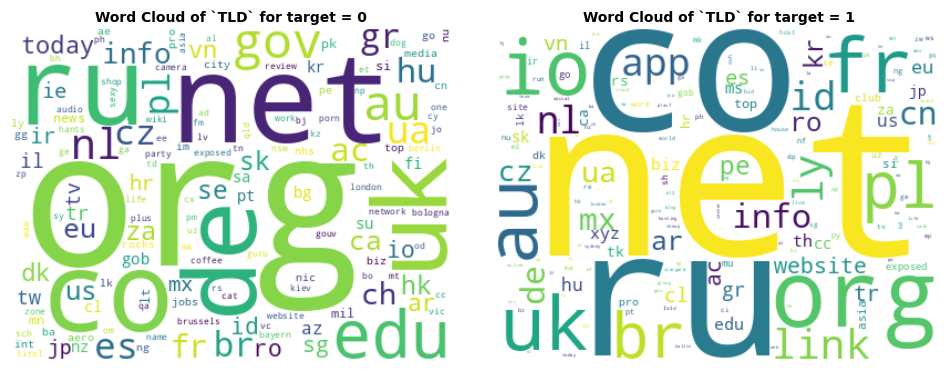

In [39]:
# plot word clouds for label 0 and label 1 to identify distinguishing keywords
# separate text by label
text0 = " ".join(df_train_sec3[df_train_sec3['target'] == 0]['tld'].dropna())
text1 = " ".join(df_train_sec3[df_train_sec3['target'] == 1]['tld'].dropna())

# create word cloud
wc0 = WordCloud(height=300, background_color='white', collocations=False).generate(text0)
wc1 = WordCloud(height=300, background_color='white', collocations=False).generate(text1)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# label = 0
axes[0].imshow(wc0, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of `TLD` for target = 0", fontsize=10, fontweight='bold')
# label = 1
axes[1].imshow(wc1, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud of `TLD` for target = 1", fontsize=10, fontweight='bold')
plt.subplots_adjust(wspace=0.1)
plt.show()

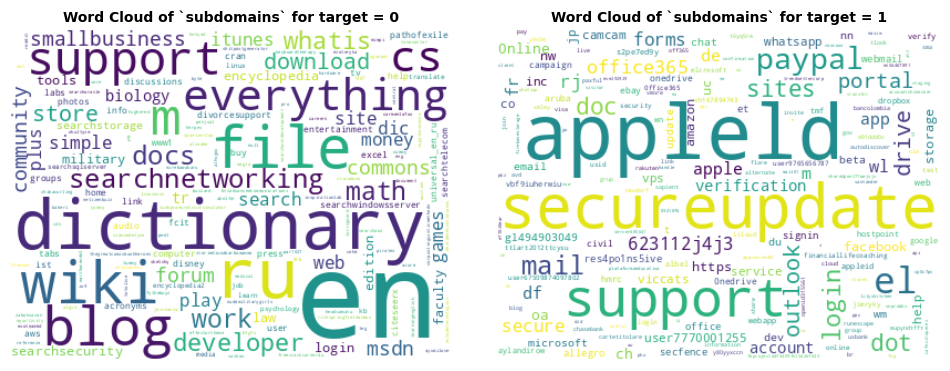

In [41]:
# plot word clouds for label 0 and label 1 to identify distinguishing keywords
# separate text by label
text0 = " ".join(df_train_sec3[df_train_sec3['target'] == 0]['subdomains'].dropna())
text1 = " ".join(df_train_sec3[df_train_sec3['target'] == 1]['subdomains'].dropna())

# create word cloud
wc0 = WordCloud(height=300, background_color='white', collocations=False).generate(text0)
wc1 = WordCloud(height=300, background_color='white', collocations=False).generate(text1)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# label = 0
axes[0].imshow(wc0, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of `subdomains` for target = 0", fontsize=10, fontweight='bold')
# label = 1
axes[1].imshow(wc1, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud of `subdomains` for target = 1", fontsize=10, fontweight='bold')
plt.subplots_adjust(wspace=0.1)
plt.show()

Plan:
- We can create features that capture common TLD ('com') and subdomains ('www')

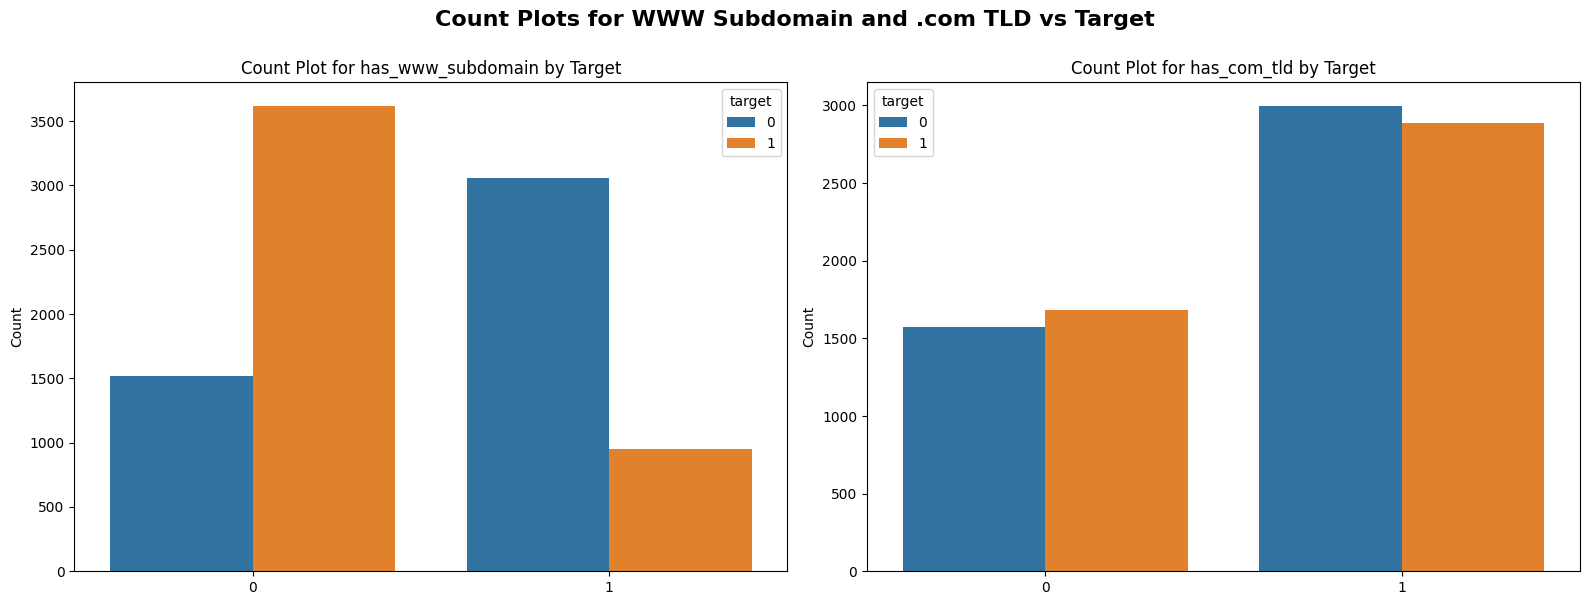

In [50]:
df_train_sec3['has_www_subdomain'] = df_train_sec3['subdomains'].apply(lambda x: 1 if x and 'www' in x.lower().split('.') else 0)
df_train_sec3['has_com_tld'] = df_train_sec3['tld'].apply(lambda x: 1 if x and 'com' in x.lower() else 0)

# plot out vs target as a subplot, put smaller size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8 * 2, 6 * 1))
axes = axes.flatten()
fig.suptitle('Count Plots for WWW Subdomain and .com TLD vs Target', fontsize=16, fontweight='bold', y=1)
# has www subdomain
ax = axes[0]
sns.countplot(data=df_train_sec3, x='has_www_subdomain', hue='target', ax=ax)
ax.set_title(f'Count Plot for has_www_subdomain by Target')
ax.set_xlabel('')
ax.set_ylabel('Count')
# has .com tld
ax = axes[1]
sns.countplot(data=df_train_sec3, x='has_com_tld', hue='target', ax=ax)
ax.set_title(f'Count Plot for has_com_tld by Target')
ax.set_xlabel('')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

#### [4.7] Generate Interaction Features

In [53]:
def engineer_interaction_features(df):

    final_df = df.copy()

    # ------------------------------
    # HTTP + Many Subdomains
    # ------------------------------
    # Attackers often use many nested subdomains to mimic legitimate domains
    # combined with unsecured HTTP. Real websites rarely have both.
    final_df['is_http_and_many_subdomains'] = (
        (final_df['is_http'] == 1) & (final_df['num_subdomain'] > 2)
    ).astype(bool)

    # ------------------------------
    # IP Address + Short TLD
    # ------------------------------
    # Legitimate domains usually have standard TLDs (.com, .net, .org, all 3-letter TLDs) and are rarely accessed via IP.
    # URLs with an IP or suspiciously short/missing TLD are highly suspicious.
    final_df['ip_and_short_tld'] = (
        final_df['is_domain_ip'] & (final_df['length_tld'] <= 2)
    ).astype(bool)

    # ------------------------------
    # HTTP + Missing Domain Structure
    # ------------------------------
    # URLs without subdomains or with very short SLD AND using HTTP are unusual.
    # Captures low-information, suspicious URLs with minimal domain structure.
    final_df['http_and_missing_domain_info'] = (
        (final_df['is_http'] == 1) &
        (final_df['has_subdomain']) &
        (final_df['length_sld'] <= 3)
    ).astype(bool)

    # ------------------------------
    # Subdomain Depth × HTTP
    # ------------------------------
    # Multiplies subdomain depth by HTTP usage to capture the intensity of suspicion.
    # Deep subdomains are more suspicious if served over HTTP.
    final_df['subdomain_depth_x_http'] = (
        final_df['num_subdomain'] * final_df['is_http']
    )

    # ------------------------------
    # IP × Protocol interactions
    # ------------------------------
    # Using an IP instead of a hostname is suspicious.
    # Combining with protocol amplifies signal:
    # - IP + HTTP is especially suspicious
    # - IP + HTTPS is rare but still unusual (not using, zero variance in dataset)
    final_df['ip_x_http'] = (final_df['is_domain_ip'] * final_df['is_http']).astype(bool)
    # final_df['ip_x_https'] = (final_df['is_domain_ip'] * final_df['is_https']).astype(bool)

    # ------------------------------
    # Domain Complexity Score
    # ------------------------------
    # Aggregates multiple weak signals into a single interpretable score:
    # - More subdomains → more suspicious
    # - Unusually short TLD (≤2 chars, likely missing or invalid) → suspicious
    # - IP usage → highly suspicious
    # Higher score → more complex / suspicious domain
    final_df['domain_complexity_score'] = (
        final_df['num_subdomain'] +
        (final_df['length_tld'] <= 2).astype(int) +
        final_df['is_domain_ip'] * 2
    )

    # ------------------------------
    # Suspicion Score
    # ------------------------------
    # Rule-based aggregate of key red flags:
    # - HTTP protocol
    # - Many subdomains
    # - IP usage
    # - Short/missing TLD (≤2 characters)
    # Higher score → more suspicious. Interpretable for stakeholders.
    final_df['suspicion_score'] = (
        final_df['is_http'] * 2 +
        (final_df['num_subdomain'] > 2).astype(int) * 2 +
        final_df['is_domain_ip'].astype(int) * 3 +
        (final_df['length_tld'] <= 2).astype(int) * 2
    )

    return final_df


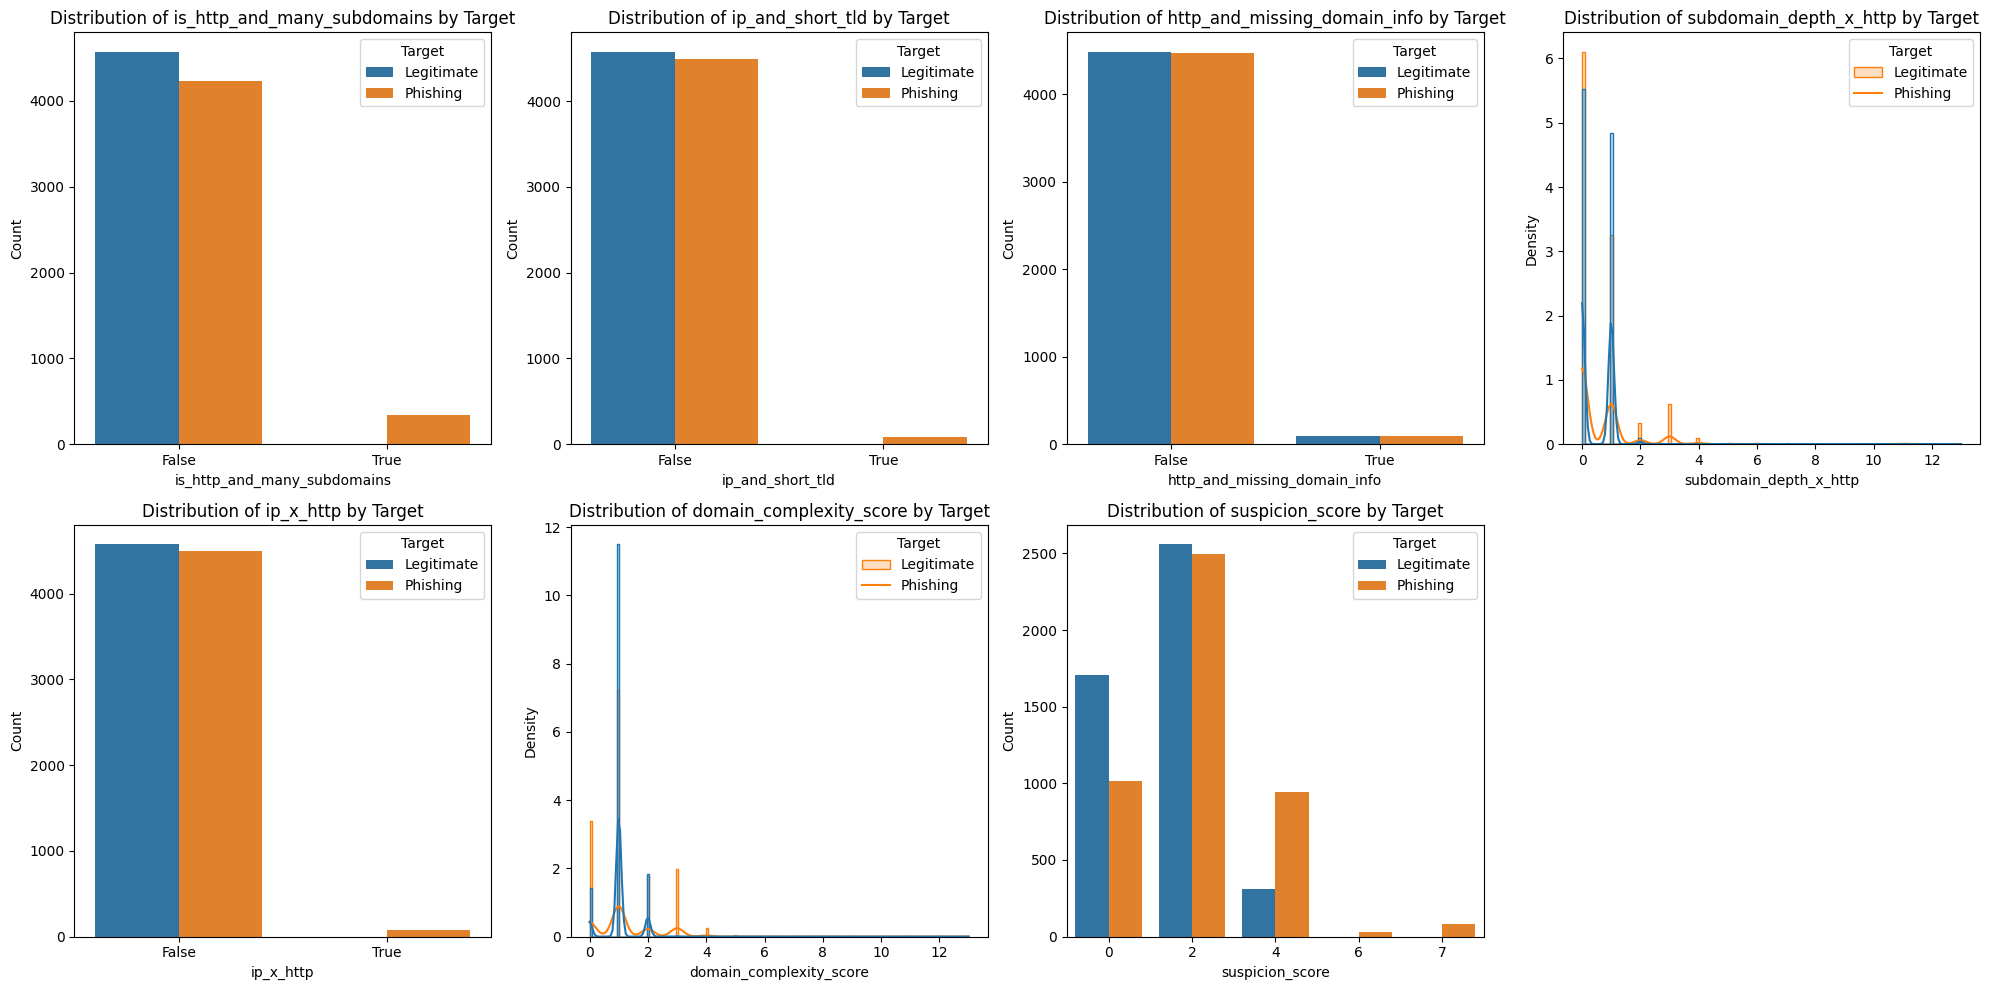

In [317]:
df_train_sec3_temp2 = engineer_interaction_features(df_train_sec3_temp)
new_features = [
    'is_http_and_many_subdomains',
    'ip_and_short_tld',
    'http_and_missing_domain_info',
    'subdomain_depth_x_http',
    'ip_x_http',
    'domain_complexity_score',  
    'suspicion_score'
]
# set 4 columns layout
n_cols = 4
n_rows = (len(new_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(new_features):
    if df_train_sec3_temp2[col].nunique() <= 10:
        sns.countplot(data=df_train_sec3_temp2, x=col, hue='target', ax=axes[i])
        axes[i].set_ylabel('Count')
    else:
        sns.histplot(data=df_train_sec3_temp2, x=col, hue='target', kde=True, element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    axes[i].legend(title='Target', labels=['Legitimate', 'Phishing'])
for i in range(len(new_features), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#### [4.8] Load in LLM Engineered Features

In [108]:
def get_llm_engineered_features(df):
    # load LLM engineered features
    llm_features = pd.read_csv('dataset/llm_engineered_dataset_new.csv')
    llm_features = llm_features.drop_duplicates(subset=['url'])
    # convert homoglyph_type to category
    llm_features['homoglyph_type'] = llm_features['homoglyph_type'].astype('category')
    llm_features = llm_features[['url', 'contains_brand_misspell', 'is_homoglyph_attack', 'homoglyph_type', 'risk_score']]
    # merge with main df
    llm_features_df = df.merge(llm_features, on='url', how='left')
    return llm_features_df

df_train_with_llm = get_llm_engineered_features(df_train_sec3)

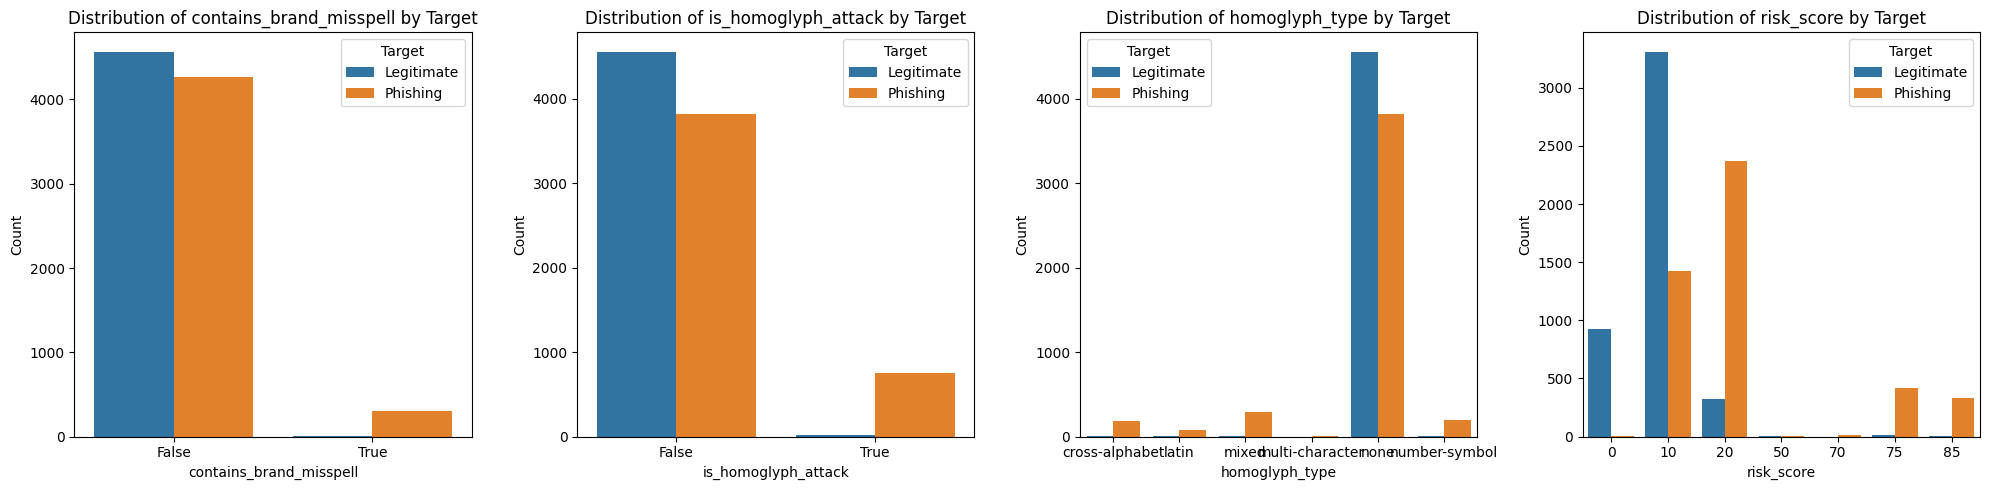

In [84]:
# define feature visualise
llm_features_list = ['contains_brand_misspell', 'is_homoglyph_attack', 'homoglyph_type', 'risk_score']

# Set 4 columns layout
n_cols = 4
n_rows = (len(llm_features_list) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(llm_features_list):
    # Check if column has <= 10 unique values (categorical/binary)
    if df_train_with_llm[col].nunique() <= 10:
        sns.countplot(data=df_train_with_llm, x=col, hue='target', ax=axes[i])
        axes[i].set_ylabel('Count')
    else:
        # For continuous variables like risk_score
        sns.histplot(data=df_train_with_llm, x=col, hue='target', kde=True, 
                    element='step', stat='density', common_norm=False, ax=axes[i])
        axes[i].set_ylabel('Density')
    
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    axes[i].legend(title='Target', labels=['Legitimate', 'Phishing'])

# Hide unused subplots
for i in range(len(llm_features_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### [4.8] Process data based on EDA findings

In [109]:
# section 4 function 
# transform based on EDA findings (create new features or drop features)
def run_section_4(df):
    # generate interaction features first
    df = engineer_interaction_features(df)

    # add in llm features
    df = get_llm_engineered_features(df)

    # convert to boolean for numerical values with large peaks
    numerical_vars_with_strong_peaks = ['num_hyphens_domain', 'length_subdomains', 
                                        'num_hyphens',  'num_at',  'num_question_marks', 'num_and',  
                                        'num_equal', 'num_percent', 'ratio_digits_url',  
                                        'ratio_digits_hostname', 'avg_word_path', 'length_query']
    for var in numerical_vars_with_strong_peaks:
        df[f'is_zero_{var}'] = (df[var] == 0).astype(bool)
    # # drop the original columns
    # df = df.drop(columns=numerical_vars_with_strong_peaks)

    # bucket the numerical variables with distinct values
    # NUM SUBDOMAIN: <1, 1, >1
    df['num_subdomain_bucketed'] = pd.cut(df['num_subdomain'], bins=[-1, 0, 1, np.inf], labels=['0', '1', 'gt1']).astype('category')
    # LENGTH TLD: <3, 3, >3
    df['length_tld_bucketed'] = pd.cut(df['length_tld'], bins=[-1, 2, 3, np.inf], labels=['lt3', '3', 'gt3']).astype('category')
    # PATH DEPTH: <2, 2-3, >3
    df['path_depth_bucketed'] = pd.cut(df['path_depth'], bins=[-1, 1, 3, np.inf], labels=['lt2', '2-3', 'gt3']).astype('category')
    # # drop the original columns
    # df = df.drop(columns=['num_subdomain', 'length_tld', 'path_depth'])

    # drop highly correlated feature
    df = df.drop(columns=['num_query_params', 'num_slashes', 'num_dots_domain', 'is_https', 'has_directory_path'])

    # drop statistical insignificant features
    df = df.drop(columns=['num_non_ascii_url'])

    # create log features 
    log_variables = ['length_url', 'length_path',  'ratio_hostname_url', 'length_words_url', 'avg_word_hostname', 'num_unique_chars_hostname']
    for var in log_variables:
        df[f"log_{var}"] = np.log1p(df[var])

    # create squared features
    squared_variables = ['ratio_letter_url', 'entropy_hostname']
    for var in squared_variables:
        df[f"squared_{var}"] = np.square(df[var])

    # for textual features
    df['has_www_subdomain'] = df['subdomains'].apply(lambda x: 1 if x and 'www' in x.lower().split('.') else 0).astype(bool)
    df['has_com_tld'] = df['tld'].apply(lambda x: 1 if x and 'com' in x.lower() else 0).astype(bool)
    
    # drop the rest of the object cols other than url
    df = df.drop(columns=[col for col in df.select_dtypes(include=['object']).columns if col != 'url'])

    return df

In [110]:
df_train_sec4 = run_section_4(df_train_sec3)

In [111]:
df_train_sec4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9143 entries, 0 to 9142
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   url                            9143 non-null   object  
 1   target                         9143 non-null   int64   
 2   is_http                        9143 non-null   bool    
 3   has_subdomain                  9143 non-null   bool    
 4   has_tld                        9143 non-null   bool    
 5   num_subdomain                  9143 non-null   int64   
 6   is_domain_ip                   9143 non-null   bool    
 7   num_hyphens_domain             9143 non-null   int64   
 8   is_punycode                    9143 non-null   bool    
 9   has_path                       9143 non-null   bool    
 10  path_depth                     9143 non-null   int64   
 11  has_filename                   9143 non-null   bool    
 12  has_file_extension             914

EDA Results for variables requiring Transformation:

for log regression:
- use log transformed version for these features ['length_url', 'length_path',  'ratio_hostname_url', 'length_words_url', 'avg_word_hostname', 'num_unique_chars_hostname']
- use squared transformed version for these features ['ratio_letter_url', 'entropy_hostname']
- use the is_zero_{feature} version for these features ['num_hyphens_domain', 'length_subdomains', 'num_hyphens',  'num_at', 'num_question_marks', 'num_and', 'num_equal', 'num_percent', 'ratio_digits_url', 'ratio_digits_hostname', 'avg_word_path', 'length_query']
- use the {feature}_bucketed version for these features ['num_subdomain', 'length_tld', 'path_depth']


In [112]:
# export for modelling section
df_train_sec4.to_csv('dataset/df_train_feature_engineered.csv', index=False)

#### [4.9] Process test data function

In [113]:
def process_test(df):
    df = run_section_2(df)
    df = run_section_3(df)
    df = run_section_4(df)
    return df

In [114]:
df_test = pd.read_csv('dataset/test.csv')
df_test_processed = process_test(df_test)

In [115]:
df_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   url                            2286 non-null   object  
 1   target                         2286 non-null   int64   
 2   is_http                        2286 non-null   bool    
 3   has_subdomain                  2286 non-null   bool    
 4   has_tld                        2286 non-null   bool    
 5   num_subdomain                  2286 non-null   int64   
 6   is_domain_ip                   2286 non-null   bool    
 7   num_hyphens_domain             2286 non-null   int64   
 8   is_punycode                    2286 non-null   bool    
 9   has_path                       2286 non-null   bool    
 10  path_depth                     2286 non-null   int64   
 11  has_filename                   2286 non-null   bool    
 12  has_file_extension             228

In [116]:
# export test for modelling
df_test_processed.to_csv('dataset/df_test_feature_engineered.csv', index=False)

# run random forest as test

In [119]:
training = pd.read_csv('dataset/df_train_feature_engineered.csv')
testing = pd.read_csv('dataset/df_test_feature_engineered.csv')

# convert the object (less url) columns to category
for col in training.select_dtypes(include=['object']).columns:
    if col != 'url':
        training[col] = training[col].astype('category')
for col in testing.select_dtypes(include=['object']).columns:
    if col != 'url':
        testing[col] = testing[col].astype('category') 

In [121]:
#fit random forest on testing
drop_for_rf = ['log_length_url', 'log_length_path',  'log_ratio_hostname_url', 'log_length_words_url', 'log_avg_word_hostname', 'log_num_unique_chars_hostname',
               'squared_ratio_letter_url', 'squared_entropy_hostname',
               'is_zero_num_hyphens_domain', 'is_zero_length_subdomains', 'is_zero_num_hyphens',  'is_zero_num_at', 'is_zero_num_question_marks', 'is_zero_num_and', 'is_zero_num_equal', 'is_zero_num_percent', 'is_zero_ratio_digits_url', 'is_zero_ratio_digits_hostname', 'is_zero_avg_word_path', 'is_zero_length_query',
               'num_subdomain_bucketed', 'length_tld_bucketed', 'path_depth_bucketed']

x_train = training.drop(columns=['url', 'target'])
x_train = x_train.drop(columns=drop_for_rf)
y_train = training['target']

x_test = testing.drop(columns=['url', 'target'])
x_test = x_test.drop(columns=drop_for_rf)

# one hot encode categorical variables (bool and category)
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [122]:
# get rocaucc on test set
y_test_pred_proba = rf.predict_proba(x_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(testing['target'], y_test_pred_proba)
print(f"ROC AUC on test set: {roc_auc:.4f}")

ROC AUC on test set: 0.9735
